In [0]:
import numpy as np
import pandas as pd
import os
import keras
from keras.models import Model
from keras.layers import Input, Activation, Lambda, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.pooling import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from keras import regularizers
from keras import initializers
from keras.layers.merge import concatenate
from keras.regularizers import l2
from keras import backend as K
from keras.layers import BatchNormalization, Dense, Flatten, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
from tqdm import tqdm_notebook as tqdm

In [0]:
def preprocess_image(img):
    img = cv2.imread(img, 0)
    # _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    img = cv2.medianBlur(img, 3)
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=-1)
    return img

In [0]:
def OneHotEncoder(labels, n_classes):
    oneHot = []
    for label in labels:
        temp = np.zeros(n_classes, dtype='int32')
        temp[label-3] = 1
        oneHot.append(temp)
    return oneHot

In [0]:
X_train = []
y_train = []

data_path = './'

train_df = pd.read_csv(data_path + 'train.csv')

In [0]:
for k,v in tqdm(train_df.values):
    X_train.append(preprocess_image(data_path + 'train/' + k))
    y_train.append(v)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [0]:
y_train = OneHotEncoder(y_train, n_classes=6)

In [0]:
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

(18432, 128, 128, 1) (18432, 6)


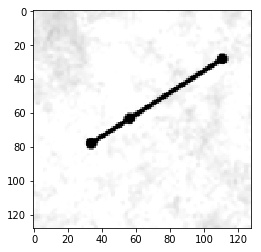

3


In [0]:
import matplotlib.pyplot as plt

plt.imshow(X_train[650][:,:,0], cmap='gray')
plt.show()
print(np.argmax(y_train[650])+3)

In [0]:
def conv2d_bn(x, nb_filter, num_row, num_col, padding='same', strides=(1, 1), use_bias=False):
    x = Conv2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x

def block_inception_a(input):
    branch_0 = conv2d_bn(input, 96, 1, 1)

    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)

    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=-1)
    return x


def block_reduction_a(input):
    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPool2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=-1)
    return x


def block_inception_b(input):
    branch_0 = conv2d_bn(input, 384, 1, 1)

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)

    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=-1)
    return x


def block_reduction_b(input):
    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=-1)
    return x


def block_inception_c(input):
    branch_0 = conv2d_bn(input, 256, 1, 1)

    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=-1)


    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=-1)

    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=-1)
    return x

def inception_v4_base(input):
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)

    branch_0 = MaxPool2D((3,3), strides=(2,2), padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

    net = concatenate([branch_0, branch_1], axis=-1)

    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=-1)

    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPool2D((3,3), strides=(2,2), padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=-1)

    for idx in range(4):
        net = block_inception_a(net)

    net = block_reduction_a(net)

    for idx in range(7):
        net = block_inception_b(net)

    net = block_reduction_b(net)

    for idx in range(3):
        net = block_inception_c(net)

    return net

def inception_v4(input_shape):
    inputs = Input(shape=input_shape)

    x = inception_v4_base(inputs)
    x = AveragePooling2D((6,6), padding='valid')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(9, activation='softmax')(x)

    model = Model(inputs, x, name='inception_v4')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
def cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (3,3), padding='valid', activation='relu')(inputs)
    x = BatchNormalization()(x)
    
    x = ZeroPadding2D()(x)
    x = Conv2D(128, (3,3), padding='valid', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = ZeroPadding2D()(x)
    x = Conv2D(128, (3,3), padding='valid', activation='relu')(x)
    x = BatchNormalization()(x)
    
#     x = ZeroPadding2D()(x)
#     x = Conv2D(512, (3,3), padding='valid', activation='relu')(x)
#     x = BatchNormalization()(x)
    
#     x = ZeroPadding2D()(x)
#     x = Conv2D(1024, (3,3), padding='valid', activation='relu')(x)
#     x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.50)(x)
    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.50)(x)
    
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.50)(x)
    
    outputs = Dense(9, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
def cnn_model_v2(input_shape):
    inputs = Input(shape=input_shape)
    
    x = BatchNormalization()(inputs)
    
    x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(9, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return model

In [0]:
def cnn_model_v2(input_shape):
    inputs = Input(shape=input_shape)
    
    x = BatchNormalization()(inputs)
    
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = keras.layers.pooling.AvgPool2D(pool_size=(3,3))(x)
    
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = keras.layers.pooling.AvgPool2D(pool_size=(3,3))(x)
    
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = keras.layers.pooling.AvgPool2D(pool_size=(3,3))(x)
    
    x = Flatten()(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(6, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    return model

In [0]:
model = cnn_model_v2((128,128,1))
print(model.summary())
checkpoint = ModelCheckpoint('cnn_weights_v6.h5', verbose=1, save_best_only=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='min')
history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, callbacks=[checkpoint, reduceLR], validation_split=0.1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 1)       4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
average_pooling2d_1 (Average (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 42, 42, 128)       512       
__________

 6560/16588 [==========>...................] - ETA: 2:01:27 - loss: 0.5792 - acc: 0.81 - ETA: 1:01:07 - loss: 0.5838 - acc: 0.79 - ETA: 41:00 - loss: 0.6083 - acc: 0.7865 - ETA: 30:55 - loss: 0.6619 - acc: 0.77 - ETA: 24:52 - loss: 0.6478 - acc: 0.78 - ETA: 20:50 - loss: 0.6264 - acc: 0.78 - ETA: 17:58 - loss: 0.6222 - acc: 0.78 - ETA: 15:50 - loss: 0.6080 - acc: 0.79 - ETA: 14:09 - loss: 0.5964 - acc: 0.79 - ETA: 12:48 - loss: 0.5909 - acc: 0.79 - ETA: 11:41 - loss: 0.5817 - acc: 0.79 - ETA: 10:46 - loss: 0.5734 - acc: 0.79 - ETA: 10:00 - loss: 0.5655 - acc: 0.79 - ETA: 9:21 - loss: 0.5632 - acc: 0.7984 - ETA: 8:47 - loss: 0.5564 - acc: 0.798 - ETA: 8:17 - loss: 0.5552 - acc: 0.798 - ETA: 7:51 - loss: 0.5574 - acc: 0.797 - ETA: 7:27 - loss: 0.5557 - acc: 0.796 - ETA: 7:05 - loss: 0.5539 - acc: 0.796 - ETA: 6:46 - loss: 0.5600 - acc: 0.795 - ETA: 6:28 - loss: 0.5526 - acc: 0.797 - ETA: 6:12 - loss: 0.5507 - acc: 0.797 - ETA: 5:57 - loss: 0.5513 - acc: 0.797 - ETA: 5:44 - loss: 0.5513 -

16588/16588 [==============================] - ETA: 13s - loss: 0.4215 - acc: 0.82 - ETA: 13s - loss: 0.4214 - acc: 0.82 - ETA: 13s - loss: 0.4214 - acc: 0.82 - ETA: 12s - loss: 0.4212 - acc: 0.82 - ETA: 12s - loss: 0.4212 - acc: 0.82 - ETA: 12s - loss: 0.4211 - acc: 0.82 - ETA: 12s - loss: 0.4210 - acc: 0.82 - ETA: 12s - loss: 0.4209 - acc: 0.82 - ETA: 12s - loss: 0.4209 - acc: 0.82 - ETA: 12s - loss: 0.4207 - acc: 0.82 - ETA: 11s - loss: 0.4206 - acc: 0.82 - ETA: 11s - loss: 0.4205 - acc: 0.82 - ETA: 11s - loss: 0.4205 - acc: 0.82 - ETA: 11s - loss: 0.4205 - acc: 0.82 - ETA: 11s - loss: 0.4204 - acc: 0.82 - ETA: 11s - loss: 0.4203 - acc: 0.82 - ETA: 11s - loss: 0.4201 - acc: 0.82 - ETA: 10s - loss: 0.4200 - acc: 0.82 - ETA: 10s - loss: 0.4199 - acc: 0.82 - ETA: 10s - loss: 0.4198 - acc: 0.82 - ETA: 10s - loss: 0.4197 - acc: 0.82 - ETA: 10s - loss: 0.4195 - acc: 0.82 - ETA: 10s - loss: 0.4195 - acc: 0.82 - ETA: 10s - loss: 0.4194 - acc: 0.82 - ETA: 9s - loss: 0.4194 - acc: 0.8294 - ET

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.3826 - acc: 0.83 - ETA: 50s - loss: 0.3820 - acc: 0.83 - ETA: 53s - loss: 0.3785 - acc: 0.83 - ETA: 54s - loss: 0.3747 - acc: 0.83 - ETA: 54s - loss: 0.3700 - acc: 0.83 - ETA: 56s - loss: 0.3714 - acc: 0.83 - ETA: 56s - loss: 0.3735 - acc: 0.84 - ETA: 55s - loss: 0.3744 - acc: 0.83 - ETA: 55s - loss: 0.3777 - acc: 0.83 - ETA: 55s - loss: 0.3762 - acc: 0.83 - ETA: 54s - loss: 0.3774 - acc: 0.83 - ETA: 54s - loss: 0.3783 - acc: 0.83 - ETA: 54s - loss: 0.3803 - acc: 0.83 - ETA: 54s - loss: 0.3808 - acc: 0.83 - ETA: 54s - loss: 0.3813 - acc: 0.83 - ETA: 53s - loss: 0.3813 - acc: 0.83 - ETA: 53s - loss: 0.3814 - acc: 0.84 - ETA: 53s - loss: 0.3812 - acc: 0.83 - ETA: 53s - loss: 0.3814 - acc: 0.83 - ETA: 53s - loss: 0.3820 - acc: 0.83 - ETA: 53s - loss: 0.3826 - acc: 0.83 - ETA: 52s - loss: 0.3819 - acc: 0.83 - ETA: 52s - loss: 0.3822 - acc: 0.83 - ETA: 52s - loss: 0.3811 - acc: 0.83 - ETA: 52s - loss: 0.3814 - acc: 0.83 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.3790 - acc: 0.838 - ETA: 9s - loss: 0.3791 - acc: 0.838 - ETA: 9s - loss: 0.3791 - acc: 0.838 - ETA: 8s - loss: 0.3790 - acc: 0.838 - ETA: 8s - loss: 0.3790 - acc: 0.838 - ETA: 8s - loss: 0.3790 - acc: 0.838 - ETA: 8s - loss: 0.3789 - acc: 0.838 - ETA: 8s - loss: 0.3789 - acc: 0.838 - ETA: 8s - loss: 0.3788 - acc: 0.838 - ETA: 8s - loss: 0.3789 - acc: 0.838 - ETA: 8s - loss: 0.3789 - acc: 0.838 - ETA: 8s - loss: 0.3789 - acc: 0.838 - ETA: 7s - loss: 0.3789 - acc: 0.838 - ETA: 7s - loss: 0.3789 - acc: 0.838 - ETA: 7s - loss: 0.3788 - acc: 0.838 - ETA: 7s - loss: 0.3788 - acc: 0.838 - ETA: 7s - loss: 0.3787 - acc: 0.838 - ETA: 7s - loss: 0.3787 - acc: 0.838 - ETA: 7s - loss: 0.3786 - acc: 0.838 - ETA: 7s - loss: 0.3787 - acc: 0.838 - ETA: 7s - loss: 0.3787 - acc: 0.838 - ETA: 6s - loss: 0.3786 - acc: 0.838 - ETA: 6s - loss: 0.3786 - acc: 0.838 - ETA: 6s - loss: 0.3786 - acc: 0.838 - ETA: 6s - loss: 0.3785 - acc: 0.838 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.3681 - acc: 0.85 - ETA: 50s - loss: 0.3583 - acc: 0.84 - ETA: 53s - loss: 0.3724 - acc: 0.84 - ETA: 52s - loss: 0.3706 - acc: 0.83 - ETA: 52s - loss: 0.3623 - acc: 0.84 - ETA: 52s - loss: 0.3538 - acc: 0.84 - ETA: 53s - loss: 0.3512 - acc: 0.84 - ETA: 53s - loss: 0.3589 - acc: 0.84 - ETA: 53s - loss: 0.3586 - acc: 0.83 - ETA: 53s - loss: 0.3589 - acc: 0.83 - ETA: 53s - loss: 0.3555 - acc: 0.84 - ETA: 52s - loss: 0.3523 - acc: 0.84 - ETA: 52s - loss: 0.3518 - acc: 0.84 - ETA: 52s - loss: 0.3516 - acc: 0.84 - ETA: 51s - loss: 0.3499 - acc: 0.84 - ETA: 51s - loss: 0.3528 - acc: 0.84 - ETA: 51s - loss: 0.3526 - acc: 0.84 - ETA: 51s - loss: 0.3528 - acc: 0.84 - ETA: 51s - loss: 0.3528 - acc: 0.84 - ETA: 50s - loss: 0.3537 - acc: 0.84 - ETA: 50s - loss: 0.3557 - acc: 0.84 - ETA: 50s - loss: 0.3546 - acc: 0.84 - ETA: 50s - loss: 0.3549 - acc: 0.84 - ETA: 50s - loss: 0.3547 - acc: 0.84 - ETA: 49s - loss: 0.3560 - acc: 0.84 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.3282 - acc: 0.844 - ETA: 8s - loss: 0.3281 - acc: 0.844 - ETA: 8s - loss: 0.3280 - acc: 0.844 - ETA: 8s - loss: 0.3280 - acc: 0.844 - ETA: 8s - loss: 0.3278 - acc: 0.844 - ETA: 8s - loss: 0.3277 - acc: 0.844 - ETA: 7s - loss: 0.3276 - acc: 0.844 - ETA: 7s - loss: 0.3275 - acc: 0.844 - ETA: 7s - loss: 0.3274 - acc: 0.844 - ETA: 7s - loss: 0.3272 - acc: 0.844 - ETA: 7s - loss: 0.3270 - acc: 0.844 - ETA: 7s - loss: 0.3268 - acc: 0.844 - ETA: 7s - loss: 0.3269 - acc: 0.844 - ETA: 7s - loss: 0.3268 - acc: 0.845 - ETA: 7s - loss: 0.3268 - acc: 0.845 - ETA: 7s - loss: 0.3267 - acc: 0.845 - ETA: 6s - loss: 0.3266 - acc: 0.845 - ETA: 6s - loss: 0.3265 - acc: 0.845 - ETA: 6s - loss: 0.3264 - acc: 0.845 - ETA: 6s - loss: 0.3263 - acc: 0.845 - ETA: 6s - loss: 0.3261 - acc: 0.845 - ETA: 6s - loss: 0.3261 - acc: 0.845 - ETA: 6s - loss: 0.3260 - acc: 0.845 - ETA: 6s - loss: 0.3259 - acc: 0.845 - ETA: 6s - loss: 0.3257 - acc: 0.845 - ETA

 6880/16588 [===========>..................] - ETA: 46s - loss: 0.2493 - acc: 0.87 - ETA: 47s - loss: 0.2813 - acc: 0.87 - ETA: 47s - loss: 0.2898 - acc: 0.86 - ETA: 47s - loss: 0.2772 - acc: 0.87 - ETA: 47s - loss: 0.2775 - acc: 0.87 - ETA: 47s - loss: 0.2764 - acc: 0.87 - ETA: 47s - loss: 0.2817 - acc: 0.86 - ETA: 47s - loss: 0.2863 - acc: 0.86 - ETA: 47s - loss: 0.2841 - acc: 0.86 - ETA: 47s - loss: 0.2849 - acc: 0.85 - ETA: 47s - loss: 0.2814 - acc: 0.86 - ETA: 47s - loss: 0.2823 - acc: 0.86 - ETA: 47s - loss: 0.2803 - acc: 0.86 - ETA: 46s - loss: 0.2817 - acc: 0.86 - ETA: 46s - loss: 0.2789 - acc: 0.86 - ETA: 46s - loss: 0.2751 - acc: 0.86 - ETA: 46s - loss: 0.2820 - acc: 0.86 - ETA: 46s - loss: 0.2816 - acc: 0.86 - ETA: 46s - loss: 0.2789 - acc: 0.86 - ETA: 46s - loss: 0.2788 - acc: 0.86 - ETA: 46s - loss: 0.2803 - acc: 0.86 - ETA: 46s - loss: 0.2812 - acc: 0.86 - ETA: 46s - loss: 0.2801 - acc: 0.86 - ETA: 46s - loss: 0.2801 - acc: 0.86 - ETA: 45s - loss: 0.2823 - acc: 0.86 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.2752 - acc: 0.866 - ETA: 8s - loss: 0.2752 - acc: 0.866 - ETA: 8s - loss: 0.2751 - acc: 0.866 - ETA: 8s - loss: 0.2752 - acc: 0.866 - ETA: 8s - loss: 0.2751 - acc: 0.866 - ETA: 8s - loss: 0.2751 - acc: 0.866 - ETA: 7s - loss: 0.2751 - acc: 0.866 - ETA: 7s - loss: 0.2748 - acc: 0.866 - ETA: 7s - loss: 0.2749 - acc: 0.866 - ETA: 7s - loss: 0.2749 - acc: 0.866 - ETA: 7s - loss: 0.2748 - acc: 0.866 - ETA: 7s - loss: 0.2747 - acc: 0.866 - ETA: 7s - loss: 0.2748 - acc: 0.866 - ETA: 7s - loss: 0.2748 - acc: 0.866 - ETA: 7s - loss: 0.2748 - acc: 0.866 - ETA: 7s - loss: 0.2747 - acc: 0.866 - ETA: 7s - loss: 0.2747 - acc: 0.866 - ETA: 6s - loss: 0.2746 - acc: 0.866 - ETA: 6s - loss: 0.2746 - acc: 0.866 - ETA: 6s - loss: 0.2745 - acc: 0.866 - ETA: 6s - loss: 0.2745 - acc: 0.866 - ETA: 6s - loss: 0.2747 - acc: 0.866 - ETA: 6s - loss: 0.2746 - acc: 0.866 - ETA: 6s - loss: 0.2747 - acc: 0.866 - ETA: 6s - loss: 0.2748 - acc: 0.866 - ETA

 6880/16588 [===========>..................] - ETA: 51s - loss: 0.2720 - acc: 0.85 - ETA: 52s - loss: 0.2747 - acc: 0.85 - ETA: 52s - loss: 0.2602 - acc: 0.86 - ETA: 58s - loss: 0.2596 - acc: 0.88 - ETA: 59s - loss: 0.2499 - acc: 0.88 - ETA: 58s - loss: 0.2503 - acc: 0.88 - ETA: 58s - loss: 0.2437 - acc: 0.88 - ETA: 57s - loss: 0.2498 - acc: 0.87 - ETA: 56s - loss: 0.2543 - acc: 0.87 - ETA: 55s - loss: 0.2489 - acc: 0.87 - ETA: 55s - loss: 0.2469 - acc: 0.88 - ETA: 55s - loss: 0.2429 - acc: 0.88 - ETA: 54s - loss: 0.2380 - acc: 0.88 - ETA: 54s - loss: 0.2387 - acc: 0.88 - ETA: 53s - loss: 0.2405 - acc: 0.88 - ETA: 53s - loss: 0.2435 - acc: 0.88 - ETA: 52s - loss: 0.2422 - acc: 0.88 - ETA: 52s - loss: 0.2429 - acc: 0.88 - ETA: 52s - loss: 0.2430 - acc: 0.88 - ETA: 51s - loss: 0.2430 - acc: 0.88 - ETA: 51s - loss: 0.2412 - acc: 0.88 - ETA: 51s - loss: 0.2401 - acc: 0.88 - ETA: 51s - loss: 0.2387 - acc: 0.88 - ETA: 50s - loss: 0.2385 - acc: 0.88 - ETA: 51s - loss: 0.2378 - acc: 0.88 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.2404 - acc: 0.886 - ETA: 9s - loss: 0.2406 - acc: 0.886 - ETA: 8s - loss: 0.2412 - acc: 0.886 - ETA: 8s - loss: 0.2411 - acc: 0.886 - ETA: 8s - loss: 0.2410 - acc: 0.886 - ETA: 8s - loss: 0.2413 - acc: 0.886 - ETA: 8s - loss: 0.2413 - acc: 0.886 - ETA: 8s - loss: 0.2413 - acc: 0.886 - ETA: 8s - loss: 0.2413 - acc: 0.886 - ETA: 8s - loss: 0.2412 - acc: 0.886 - ETA: 8s - loss: 0.2413 - acc: 0.886 - ETA: 7s - loss: 0.2414 - acc: 0.886 - ETA: 7s - loss: 0.2415 - acc: 0.885 - ETA: 7s - loss: 0.2413 - acc: 0.886 - ETA: 7s - loss: 0.2412 - acc: 0.886 - ETA: 7s - loss: 0.2413 - acc: 0.885 - ETA: 7s - loss: 0.2413 - acc: 0.885 - ETA: 7s - loss: 0.2411 - acc: 0.886 - ETA: 7s - loss: 0.2411 - acc: 0.886 - ETA: 7s - loss: 0.2410 - acc: 0.886 - ETA: 7s - loss: 0.2410 - acc: 0.886 - ETA: 6s - loss: 0.2410 - acc: 0.886 - ETA: 6s - loss: 0.2410 - acc: 0.886 - ETA: 6s - loss: 0.2409 - acc: 0.886 - ETA: 6s - loss: 0.2408 - acc: 0.886 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.2429 - acc: 0.90 - ETA: 49s - loss: 0.2097 - acc: 0.92 - ETA: 49s - loss: 0.2226 - acc: 0.90 - ETA: 49s - loss: 0.2289 - acc: 0.90 - ETA: 49s - loss: 0.2300 - acc: 0.89 - ETA: 49s - loss: 0.2523 - acc: 0.88 - ETA: 49s - loss: 0.2516 - acc: 0.88 - ETA: 48s - loss: 0.2430 - acc: 0.88 - ETA: 48s - loss: 0.2380 - acc: 0.89 - ETA: 48s - loss: 0.2325 - acc: 0.89 - ETA: 48s - loss: 0.2274 - acc: 0.89 - ETA: 48s - loss: 0.2292 - acc: 0.89 - ETA: 48s - loss: 0.2241 - acc: 0.89 - ETA: 48s - loss: 0.2262 - acc: 0.89 - ETA: 48s - loss: 0.2247 - acc: 0.89 - ETA: 48s - loss: 0.2304 - acc: 0.89 - ETA: 48s - loss: 0.2325 - acc: 0.89 - ETA: 48s - loss: 0.2302 - acc: 0.89 - ETA: 48s - loss: 0.2307 - acc: 0.89 - ETA: 48s - loss: 0.2316 - acc: 0.89 - ETA: 47s - loss: 0.2328 - acc: 0.89 - ETA: 47s - loss: 0.2343 - acc: 0.89 - ETA: 47s - loss: 0.2370 - acc: 0.89 - ETA: 47s - loss: 0.2372 - acc: 0.89 - ETA: 47s - loss: 0.2380 - acc: 0.89 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.2161 - acc: 0.900 - ETA: 8s - loss: 0.2160 - acc: 0.900 - ETA: 8s - loss: 0.2159 - acc: 0.900 - ETA: 8s - loss: 0.2158 - acc: 0.900 - ETA: 8s - loss: 0.2158 - acc: 0.900 - ETA: 8s - loss: 0.2158 - acc: 0.900 - ETA: 8s - loss: 0.2157 - acc: 0.900 - ETA: 8s - loss: 0.2157 - acc: 0.900 - ETA: 7s - loss: 0.2157 - acc: 0.901 - ETA: 7s - loss: 0.2156 - acc: 0.900 - ETA: 7s - loss: 0.2156 - acc: 0.901 - ETA: 7s - loss: 0.2156 - acc: 0.901 - ETA: 7s - loss: 0.2158 - acc: 0.900 - ETA: 7s - loss: 0.2158 - acc: 0.900 - ETA: 7s - loss: 0.2157 - acc: 0.900 - ETA: 7s - loss: 0.2156 - acc: 0.900 - ETA: 7s - loss: 0.2159 - acc: 0.900 - ETA: 7s - loss: 0.2159 - acc: 0.900 - ETA: 6s - loss: 0.2160 - acc: 0.900 - ETA: 6s - loss: 0.2162 - acc: 0.900 - ETA: 6s - loss: 0.2162 - acc: 0.900 - ETA: 6s - loss: 0.2164 - acc: 0.900 - ETA: 6s - loss: 0.2165 - acc: 0.900 - ETA: 6s - loss: 0.2166 - acc: 0.900 - ETA: 6s - loss: 0.2165 - acc: 0.900 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.2028 - acc: 0.90 - ETA: 48s - loss: 0.2353 - acc: 0.90 - ETA: 49s - loss: 0.2157 - acc: 0.90 - ETA: 50s - loss: 0.2086 - acc: 0.90 - ETA: 49s - loss: 0.2023 - acc: 0.91 - ETA: 49s - loss: 0.1977 - acc: 0.91 - ETA: 50s - loss: 0.1904 - acc: 0.92 - ETA: 50s - loss: 0.1869 - acc: 0.92 - ETA: 50s - loss: 0.1863 - acc: 0.92 - ETA: 50s - loss: 0.1825 - acc: 0.92 - ETA: 49s - loss: 0.1884 - acc: 0.92 - ETA: 49s - loss: 0.1995 - acc: 0.91 - ETA: 49s - loss: 0.1958 - acc: 0.91 - ETA: 49s - loss: 0.1933 - acc: 0.91 - ETA: 49s - loss: 0.1908 - acc: 0.91 - ETA: 49s - loss: 0.1927 - acc: 0.91 - ETA: 49s - loss: 0.1931 - acc: 0.91 - ETA: 49s - loss: 0.1952 - acc: 0.91 - ETA: 49s - loss: 0.1920 - acc: 0.91 - ETA: 49s - loss: 0.1885 - acc: 0.91 - ETA: 49s - loss: 0.1890 - acc: 0.91 - ETA: 49s - loss: 0.1891 - acc: 0.91 - ETA: 49s - loss: 0.1974 - acc: 0.91 - ETA: 49s - loss: 0.1955 - acc: 0.91 - ETA: 49s - loss: 0.1964 - acc: 0.90 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.1944 - acc: 0.912 - ETA: 8s - loss: 0.1943 - acc: 0.913 - ETA: 8s - loss: 0.1943 - acc: 0.913 - ETA: 8s - loss: 0.1943 - acc: 0.913 - ETA: 8s - loss: 0.1945 - acc: 0.912 - ETA: 8s - loss: 0.1945 - acc: 0.913 - ETA: 8s - loss: 0.1946 - acc: 0.912 - ETA: 8s - loss: 0.1944 - acc: 0.913 - ETA: 7s - loss: 0.1943 - acc: 0.913 - ETA: 7s - loss: 0.1942 - acc: 0.913 - ETA: 7s - loss: 0.1943 - acc: 0.913 - ETA: 7s - loss: 0.1943 - acc: 0.913 - ETA: 7s - loss: 0.1942 - acc: 0.913 - ETA: 7s - loss: 0.1940 - acc: 0.913 - ETA: 7s - loss: 0.1939 - acc: 0.913 - ETA: 7s - loss: 0.1940 - acc: 0.913 - ETA: 7s - loss: 0.1942 - acc: 0.913 - ETA: 7s - loss: 0.1940 - acc: 0.913 - ETA: 6s - loss: 0.1939 - acc: 0.913 - ETA: 6s - loss: 0.1939 - acc: 0.913 - ETA: 6s - loss: 0.1938 - acc: 0.913 - ETA: 6s - loss: 0.1943 - acc: 0.912 - ETA: 6s - loss: 0.1943 - acc: 0.912 - ETA: 6s - loss: 0.1942 - acc: 0.912 - ETA: 6s - loss: 0.1943 - acc: 0.912 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.1199 - acc: 0.95 - ETA: 49s - loss: 0.1693 - acc: 0.93 - ETA: 49s - loss: 0.1608 - acc: 0.93 - ETA: 50s - loss: 0.1858 - acc: 0.91 - ETA: 50s - loss: 0.1844 - acc: 0.92 - ETA: 50s - loss: 0.1790 - acc: 0.92 - ETA: 50s - loss: 0.1734 - acc: 0.92 - ETA: 50s - loss: 0.1735 - acc: 0.92 - ETA: 50s - loss: 0.1660 - acc: 0.92 - ETA: 50s - loss: 0.1642 - acc: 0.92 - ETA: 50s - loss: 0.1622 - acc: 0.92 - ETA: 50s - loss: 0.1623 - acc: 0.92 - ETA: 50s - loss: 0.1632 - acc: 0.92 - ETA: 50s - loss: 0.1630 - acc: 0.92 - ETA: 50s - loss: 0.1617 - acc: 0.93 - ETA: 50s - loss: 0.1596 - acc: 0.93 - ETA: 50s - loss: 0.1659 - acc: 0.92 - ETA: 49s - loss: 0.1707 - acc: 0.92 - ETA: 49s - loss: 0.1713 - acc: 0.92 - ETA: 49s - loss: 0.1786 - acc: 0.92 - ETA: 49s - loss: 0.1801 - acc: 0.91 - ETA: 49s - loss: 0.1799 - acc: 0.91 - ETA: 49s - loss: 0.1841 - acc: 0.91 - ETA: 49s - loss: 0.1867 - acc: 0.91 - ETA: 49s - loss: 0.1864 - acc: 0.91 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.1834 - acc: 0.918 - ETA: 8s - loss: 0.1834 - acc: 0.918 - ETA: 8s - loss: 0.1833 - acc: 0.918 - ETA: 8s - loss: 0.1833 - acc: 0.918 - ETA: 8s - loss: 0.1833 - acc: 0.918 - ETA: 8s - loss: 0.1836 - acc: 0.918 - ETA: 8s - loss: 0.1837 - acc: 0.918 - ETA: 8s - loss: 0.1837 - acc: 0.918 - ETA: 7s - loss: 0.1838 - acc: 0.918 - ETA: 7s - loss: 0.1837 - acc: 0.918 - ETA: 7s - loss: 0.1837 - acc: 0.918 - ETA: 7s - loss: 0.1837 - acc: 0.918 - ETA: 7s - loss: 0.1837 - acc: 0.918 - ETA: 7s - loss: 0.1838 - acc: 0.918 - ETA: 7s - loss: 0.1836 - acc: 0.918 - ETA: 7s - loss: 0.1836 - acc: 0.918 - ETA: 7s - loss: 0.1836 - acc: 0.918 - ETA: 7s - loss: 0.1836 - acc: 0.918 - ETA: 6s - loss: 0.1836 - acc: 0.918 - ETA: 6s - loss: 0.1835 - acc: 0.918 - ETA: 6s - loss: 0.1834 - acc: 0.918 - ETA: 6s - loss: 0.1834 - acc: 0.918 - ETA: 6s - loss: 0.1834 - acc: 0.918 - ETA: 6s - loss: 0.1832 - acc: 0.918 - ETA: 6s - loss: 0.1831 - acc: 0.918 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.2341 - acc: 0.85 - ETA: 49s - loss: 0.1995 - acc: 0.88 - ETA: 49s - loss: 0.2308 - acc: 0.87 - ETA: 49s - loss: 0.2221 - acc: 0.88 - ETA: 49s - loss: 0.2072 - acc: 0.90 - ETA: 49s - loss: 0.1909 - acc: 0.91 - ETA: 49s - loss: 0.1764 - acc: 0.92 - ETA: 49s - loss: 0.1822 - acc: 0.91 - ETA: 49s - loss: 0.1776 - acc: 0.91 - ETA: 49s - loss: 0.1743 - acc: 0.92 - ETA: 49s - loss: 0.1795 - acc: 0.91 - ETA: 49s - loss: 0.1789 - acc: 0.91 - ETA: 49s - loss: 0.1750 - acc: 0.91 - ETA: 49s - loss: 0.1711 - acc: 0.92 - ETA: 49s - loss: 0.1689 - acc: 0.92 - ETA: 49s - loss: 0.1648 - acc: 0.92 - ETA: 49s - loss: 0.1717 - acc: 0.92 - ETA: 49s - loss: 0.1707 - acc: 0.92 - ETA: 49s - loss: 0.1707 - acc: 0.92 - ETA: 49s - loss: 0.1686 - acc: 0.92 - ETA: 48s - loss: 0.1696 - acc: 0.92 - ETA: 48s - loss: 0.1727 - acc: 0.92 - ETA: 48s - loss: 0.1705 - acc: 0.92 - ETA: 48s - loss: 0.1697 - acc: 0.92 - ETA: 48s - loss: 0.1681 - acc: 0.92 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.1712 - acc: 0.925 - ETA: 8s - loss: 0.1711 - acc: 0.925 - ETA: 8s - loss: 0.1712 - acc: 0.925 - ETA: 8s - loss: 0.1710 - acc: 0.925 - ETA: 8s - loss: 0.1710 - acc: 0.925 - ETA: 8s - loss: 0.1710 - acc: 0.925 - ETA: 8s - loss: 0.1709 - acc: 0.925 - ETA: 8s - loss: 0.1709 - acc: 0.925 - ETA: 8s - loss: 0.1710 - acc: 0.925 - ETA: 8s - loss: 0.1709 - acc: 0.925 - ETA: 8s - loss: 0.1708 - acc: 0.925 - ETA: 7s - loss: 0.1707 - acc: 0.925 - ETA: 7s - loss: 0.1708 - acc: 0.925 - ETA: 7s - loss: 0.1706 - acc: 0.925 - ETA: 7s - loss: 0.1708 - acc: 0.925 - ETA: 7s - loss: 0.1707 - acc: 0.925 - ETA: 7s - loss: 0.1705 - acc: 0.925 - ETA: 7s - loss: 0.1704 - acc: 0.925 - ETA: 7s - loss: 0.1704 - acc: 0.925 - ETA: 7s - loss: 0.1703 - acc: 0.925 - ETA: 6s - loss: 0.1702 - acc: 0.925 - ETA: 6s - loss: 0.1702 - acc: 0.925 - ETA: 6s - loss: 0.1701 - acc: 0.925 - ETA: 6s - loss: 0.1702 - acc: 0.925 - ETA: 6s - loss: 0.1705 - acc: 0.925 - ETA

 6880/16588 [===========>..................] - ETA: 46s - loss: 0.1495 - acc: 0.94 - ETA: 48s - loss: 0.1302 - acc: 0.95 - ETA: 48s - loss: 0.1291 - acc: 0.95 - ETA: 49s - loss: 0.1256 - acc: 0.95 - ETA: 49s - loss: 0.1252 - acc: 0.95 - ETA: 49s - loss: 0.1185 - acc: 0.95 - ETA: 49s - loss: 0.1223 - acc: 0.95 - ETA: 49s - loss: 0.1247 - acc: 0.95 - ETA: 49s - loss: 0.1242 - acc: 0.95 - ETA: 49s - loss: 0.1275 - acc: 0.95 - ETA: 49s - loss: 0.1366 - acc: 0.94 - ETA: 49s - loss: 0.1372 - acc: 0.94 - ETA: 49s - loss: 0.1410 - acc: 0.94 - ETA: 49s - loss: 0.1414 - acc: 0.94 - ETA: 49s - loss: 0.1448 - acc: 0.94 - ETA: 49s - loss: 0.1432 - acc: 0.94 - ETA: 49s - loss: 0.1434 - acc: 0.94 - ETA: 49s - loss: 0.1422 - acc: 0.94 - ETA: 49s - loss: 0.1417 - acc: 0.94 - ETA: 49s - loss: 0.1417 - acc: 0.94 - ETA: 49s - loss: 0.1439 - acc: 0.94 - ETA: 49s - loss: 0.1436 - acc: 0.94 - ETA: 49s - loss: 0.1437 - acc: 0.94 - ETA: 49s - loss: 0.1443 - acc: 0.94 - ETA: 49s - loss: 0.1435 - acc: 0.94 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.1552 - acc: 0.934 - ETA: 8s - loss: 0.1554 - acc: 0.934 - ETA: 8s - loss: 0.1553 - acc: 0.933 - ETA: 8s - loss: 0.1553 - acc: 0.934 - ETA: 8s - loss: 0.1552 - acc: 0.934 - ETA: 8s - loss: 0.1551 - acc: 0.934 - ETA: 8s - loss: 0.1550 - acc: 0.934 - ETA: 8s - loss: 0.1549 - acc: 0.934 - ETA: 7s - loss: 0.1551 - acc: 0.934 - ETA: 7s - loss: 0.1550 - acc: 0.934 - ETA: 7s - loss: 0.1550 - acc: 0.934 - ETA: 7s - loss: 0.1551 - acc: 0.934 - ETA: 7s - loss: 0.1551 - acc: 0.934 - ETA: 7s - loss: 0.1552 - acc: 0.934 - ETA: 7s - loss: 0.1552 - acc: 0.934 - ETA: 7s - loss: 0.1551 - acc: 0.934 - ETA: 7s - loss: 0.1553 - acc: 0.934 - ETA: 7s - loss: 0.1553 - acc: 0.934 - ETA: 6s - loss: 0.1554 - acc: 0.934 - ETA: 6s - loss: 0.1555 - acc: 0.934 - ETA: 6s - loss: 0.1556 - acc: 0.933 - ETA: 6s - loss: 0.1555 - acc: 0.933 - ETA: 6s - loss: 0.1555 - acc: 0.934 - ETA: 6s - loss: 0.1559 - acc: 0.933 - ETA: 6s - loss: 0.1560 - acc: 0.933 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.1402 - acc: 0.94 - ETA: 55s - loss: 0.1383 - acc: 0.93 - ETA: 57s - loss: 0.1423 - acc: 0.93 - ETA: 56s - loss: 0.1445 - acc: 0.93 - ETA: 55s - loss: 0.1586 - acc: 0.92 - ETA: 55s - loss: 0.1555 - acc: 0.92 - ETA: 54s - loss: 0.1473 - acc: 0.93 - ETA: 53s - loss: 0.1413 - acc: 0.93 - ETA: 52s - loss: 0.1386 - acc: 0.93 - ETA: 52s - loss: 0.1402 - acc: 0.93 - ETA: 51s - loss: 0.1405 - acc: 0.93 - ETA: 51s - loss: 0.1376 - acc: 0.93 - ETA: 51s - loss: 0.1389 - acc: 0.93 - ETA: 51s - loss: 0.1420 - acc: 0.93 - ETA: 50s - loss: 0.1405 - acc: 0.93 - ETA: 50s - loss: 0.1373 - acc: 0.93 - ETA: 50s - loss: 0.1381 - acc: 0.93 - ETA: 50s - loss: 0.1400 - acc: 0.93 - ETA: 50s - loss: 0.1464 - acc: 0.93 - ETA: 50s - loss: 0.1458 - acc: 0.93 - ETA: 50s - loss: 0.1454 - acc: 0.93 - ETA: 49s - loss: 0.1441 - acc: 0.93 - ETA: 49s - loss: 0.1437 - acc: 0.93 - ETA: 49s - loss: 0.1410 - acc: 0.93 - ETA: 49s - loss: 0.1452 - acc: 0.93 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.1482 - acc: 0.937 - ETA: 8s - loss: 0.1482 - acc: 0.937 - ETA: 8s - loss: 0.1483 - acc: 0.937 - ETA: 8s - loss: 0.1483 - acc: 0.937 - ETA: 8s - loss: 0.1481 - acc: 0.937 - ETA: 8s - loss: 0.1480 - acc: 0.937 - ETA: 8s - loss: 0.1481 - acc: 0.937 - ETA: 8s - loss: 0.1482 - acc: 0.937 - ETA: 8s - loss: 0.1481 - acc: 0.937 - ETA: 8s - loss: 0.1480 - acc: 0.937 - ETA: 7s - loss: 0.1480 - acc: 0.937 - ETA: 7s - loss: 0.1484 - acc: 0.937 - ETA: 7s - loss: 0.1485 - acc: 0.937 - ETA: 7s - loss: 0.1486 - acc: 0.937 - ETA: 7s - loss: 0.1485 - acc: 0.937 - ETA: 7s - loss: 0.1484 - acc: 0.937 - ETA: 7s - loss: 0.1483 - acc: 0.937 - ETA: 7s - loss: 0.1485 - acc: 0.937 - ETA: 7s - loss: 0.1485 - acc: 0.937 - ETA: 7s - loss: 0.1484 - acc: 0.937 - ETA: 6s - loss: 0.1484 - acc: 0.937 - ETA: 6s - loss: 0.1482 - acc: 0.937 - ETA: 6s - loss: 0.1484 - acc: 0.937 - ETA: 6s - loss: 0.1484 - acc: 0.937 - ETA: 6s - loss: 0.1484 - acc: 0.937 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.2460 - acc: 0.87 - ETA: 48s - loss: 0.1939 - acc: 0.90 - ETA: 49s - loss: 0.1593 - acc: 0.92 - ETA: 50s - loss: 0.1449 - acc: 0.93 - ETA: 50s - loss: 0.1533 - acc: 0.92 - ETA: 50s - loss: 0.1511 - acc: 0.92 - ETA: 50s - loss: 0.1423 - acc: 0.92 - ETA: 50s - loss: 0.1375 - acc: 0.93 - ETA: 50s - loss: 0.1326 - acc: 0.93 - ETA: 50s - loss: 0.1327 - acc: 0.93 - ETA: 50s - loss: 0.1350 - acc: 0.93 - ETA: 50s - loss: 0.1324 - acc: 0.93 - ETA: 50s - loss: 0.1312 - acc: 0.93 - ETA: 50s - loss: 0.1356 - acc: 0.93 - ETA: 50s - loss: 0.1331 - acc: 0.93 - ETA: 49s - loss: 0.1373 - acc: 0.93 - ETA: 49s - loss: 0.1379 - acc: 0.93 - ETA: 49s - loss: 0.1347 - acc: 0.93 - ETA: 49s - loss: 0.1306 - acc: 0.93 - ETA: 49s - loss: 0.1295 - acc: 0.93 - ETA: 49s - loss: 0.1279 - acc: 0.94 - ETA: 49s - loss: 0.1271 - acc: 0.94 - ETA: 49s - loss: 0.1339 - acc: 0.93 - ETA: 49s - loss: 0.1321 - acc: 0.93 - ETA: 49s - loss: 0.1327 - acc: 0.93 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.1376 - acc: 0.942 - ETA: 8s - loss: 0.1382 - acc: 0.942 - ETA: 8s - loss: 0.1383 - acc: 0.942 - ETA: 8s - loss: 0.1382 - acc: 0.942 - ETA: 8s - loss: 0.1381 - acc: 0.942 - ETA: 8s - loss: 0.1380 - acc: 0.942 - ETA: 8s - loss: 0.1380 - acc: 0.942 - ETA: 8s - loss: 0.1380 - acc: 0.942 - ETA: 7s - loss: 0.1379 - acc: 0.942 - ETA: 7s - loss: 0.1378 - acc: 0.942 - ETA: 7s - loss: 0.1379 - acc: 0.942 - ETA: 7s - loss: 0.1379 - acc: 0.942 - ETA: 7s - loss: 0.1379 - acc: 0.942 - ETA: 7s - loss: 0.1379 - acc: 0.942 - ETA: 7s - loss: 0.1380 - acc: 0.942 - ETA: 7s - loss: 0.1379 - acc: 0.942 - ETA: 7s - loss: 0.1379 - acc: 0.942 - ETA: 7s - loss: 0.1377 - acc: 0.942 - ETA: 6s - loss: 0.1377 - acc: 0.942 - ETA: 6s - loss: 0.1377 - acc: 0.942 - ETA: 6s - loss: 0.1377 - acc: 0.942 - ETA: 6s - loss: 0.1377 - acc: 0.942 - ETA: 6s - loss: 0.1376 - acc: 0.942 - ETA: 6s - loss: 0.1375 - acc: 0.942 - ETA: 6s - loss: 0.1376 - acc: 0.942 - ETA

 6880/16588 [===========>..................] - ETA: 52s - loss: 0.0655 - acc: 0.95 - ETA: 51s - loss: 0.0996 - acc: 0.95 - ETA: 51s - loss: 0.0932 - acc: 0.96 - ETA: 51s - loss: 0.1134 - acc: 0.95 - ETA: 50s - loss: 0.1168 - acc: 0.95 - ETA: 50s - loss: 0.1119 - acc: 0.95 - ETA: 50s - loss: 0.1083 - acc: 0.95 - ETA: 49s - loss: 0.1114 - acc: 0.95 - ETA: 49s - loss: 0.1118 - acc: 0.95 - ETA: 49s - loss: 0.1091 - acc: 0.95 - ETA: 49s - loss: 0.1098 - acc: 0.95 - ETA: 49s - loss: 0.1152 - acc: 0.95 - ETA: 49s - loss: 0.1225 - acc: 0.95 - ETA: 48s - loss: 0.1195 - acc: 0.95 - ETA: 48s - loss: 0.1164 - acc: 0.95 - ETA: 48s - loss: 0.1159 - acc: 0.95 - ETA: 48s - loss: 0.1145 - acc: 0.95 - ETA: 48s - loss: 0.1271 - acc: 0.94 - ETA: 48s - loss: 0.1299 - acc: 0.94 - ETA: 48s - loss: 0.1303 - acc: 0.94 - ETA: 48s - loss: 0.1293 - acc: 0.94 - ETA: 48s - loss: 0.1339 - acc: 0.94 - ETA: 48s - loss: 0.1413 - acc: 0.93 - ETA: 48s - loss: 0.1412 - acc: 0.93 - ETA: 48s - loss: 0.1409 - acc: 0.93 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.1343 - acc: 0.943 - ETA: 8s - loss: 0.1343 - acc: 0.943 - ETA: 8s - loss: 0.1341 - acc: 0.943 - ETA: 8s - loss: 0.1340 - acc: 0.943 - ETA: 8s - loss: 0.1338 - acc: 0.943 - ETA: 8s - loss: 0.1337 - acc: 0.943 - ETA: 8s - loss: 0.1338 - acc: 0.943 - ETA: 8s - loss: 0.1338 - acc: 0.943 - ETA: 8s - loss: 0.1342 - acc: 0.943 - ETA: 8s - loss: 0.1341 - acc: 0.943 - ETA: 7s - loss: 0.1342 - acc: 0.943 - ETA: 7s - loss: 0.1341 - acc: 0.943 - ETA: 7s - loss: 0.1340 - acc: 0.943 - ETA: 7s - loss: 0.1340 - acc: 0.943 - ETA: 7s - loss: 0.1339 - acc: 0.943 - ETA: 7s - loss: 0.1338 - acc: 0.943 - ETA: 7s - loss: 0.1340 - acc: 0.943 - ETA: 7s - loss: 0.1339 - acc: 0.943 - ETA: 7s - loss: 0.1338 - acc: 0.943 - ETA: 6s - loss: 0.1339 - acc: 0.943 - ETA: 6s - loss: 0.1337 - acc: 0.943 - ETA: 6s - loss: 0.1337 - acc: 0.943 - ETA: 6s - loss: 0.1340 - acc: 0.943 - ETA: 6s - loss: 0.1339 - acc: 0.943 - ETA: 6s - loss: 0.1339 - acc: 0.943 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.0597 - acc: 0.98 - ETA: 49s - loss: 0.0805 - acc: 0.97 - ETA: 51s - loss: 0.0967 - acc: 0.96 - ETA: 52s - loss: 0.0890 - acc: 0.96 - ETA: 53s - loss: 0.1066 - acc: 0.95 - ETA: 52s - loss: 0.1088 - acc: 0.94 - ETA: 52s - loss: 0.1120 - acc: 0.95 - ETA: 52s - loss: 0.1168 - acc: 0.94 - ETA: 51s - loss: 0.1154 - acc: 0.94 - ETA: 51s - loss: 0.1128 - acc: 0.95 - ETA: 51s - loss: 0.1083 - acc: 0.95 - ETA: 52s - loss: 0.1192 - acc: 0.95 - ETA: 52s - loss: 0.1137 - acc: 0.95 - ETA: 51s - loss: 0.1125 - acc: 0.95 - ETA: 51s - loss: 0.1112 - acc: 0.95 - ETA: 51s - loss: 0.1089 - acc: 0.95 - ETA: 51s - loss: 0.1087 - acc: 0.95 - ETA: 50s - loss: 0.1133 - acc: 0.95 - ETA: 50s - loss: 0.1154 - acc: 0.95 - ETA: 50s - loss: 0.1134 - acc: 0.95 - ETA: 50s - loss: 0.1133 - acc: 0.95 - ETA: 50s - loss: 0.1299 - acc: 0.94 - ETA: 49s - loss: 0.1289 - acc: 0.94 - ETA: 49s - loss: 0.1278 - acc: 0.94 - ETA: 49s - loss: 0.1276 - acc: 0.94 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.1272 - acc: 0.947 - ETA: 8s - loss: 0.1272 - acc: 0.947 - ETA: 8s - loss: 0.1278 - acc: 0.946 - ETA: 8s - loss: 0.1278 - acc: 0.946 - ETA: 8s - loss: 0.1276 - acc: 0.946 - ETA: 8s - loss: 0.1276 - acc: 0.946 - ETA: 8s - loss: 0.1274 - acc: 0.947 - ETA: 8s - loss: 0.1276 - acc: 0.946 - ETA: 8s - loss: 0.1277 - acc: 0.946 - ETA: 8s - loss: 0.1278 - acc: 0.946 - ETA: 7s - loss: 0.1280 - acc: 0.946 - ETA: 7s - loss: 0.1282 - acc: 0.946 - ETA: 7s - loss: 0.1284 - acc: 0.946 - ETA: 7s - loss: 0.1285 - acc: 0.946 - ETA: 7s - loss: 0.1285 - acc: 0.946 - ETA: 7s - loss: 0.1285 - acc: 0.946 - ETA: 7s - loss: 0.1283 - acc: 0.946 - ETA: 7s - loss: 0.1283 - acc: 0.946 - ETA: 7s - loss: 0.1283 - acc: 0.946 - ETA: 7s - loss: 0.1283 - acc: 0.946 - ETA: 6s - loss: 0.1283 - acc: 0.946 - ETA: 6s - loss: 0.1282 - acc: 0.946 - ETA: 6s - loss: 0.1281 - acc: 0.946 - ETA: 6s - loss: 0.1282 - acc: 0.946 - ETA: 6s - loss: 0.1281 - acc: 0.946 - ETA

 6880/16588 [===========>..................] - ETA: 53s - loss: 0.1531 - acc: 0.94 - ETA: 55s - loss: 0.1224 - acc: 0.95 - ETA: 56s - loss: 0.1152 - acc: 0.96 - ETA: 57s - loss: 0.1178 - acc: 0.95 - ETA: 58s - loss: 0.1238 - acc: 0.95 - ETA: 58s - loss: 0.1208 - acc: 0.95 - ETA: 57s - loss: 0.1209 - acc: 0.95 - ETA: 57s - loss: 0.1285 - acc: 0.95 - ETA: 57s - loss: 0.1232 - acc: 0.95 - ETA: 56s - loss: 0.1230 - acc: 0.95 - ETA: 55s - loss: 0.1196 - acc: 0.95 - ETA: 55s - loss: 0.1152 - acc: 0.95 - ETA: 54s - loss: 0.1131 - acc: 0.95 - ETA: 54s - loss: 0.1092 - acc: 0.95 - ETA: 53s - loss: 0.1118 - acc: 0.95 - ETA: 53s - loss: 0.1108 - acc: 0.95 - ETA: 52s - loss: 0.1109 - acc: 0.95 - ETA: 52s - loss: 0.1090 - acc: 0.95 - ETA: 52s - loss: 0.1143 - acc: 0.95 - ETA: 51s - loss: 0.1174 - acc: 0.95 - ETA: 51s - loss: 0.1193 - acc: 0.95 - ETA: 51s - loss: 0.1203 - acc: 0.95 - ETA: 51s - loss: 0.1212 - acc: 0.95 - ETA: 51s - loss: 0.1192 - acc: 0.95 - ETA: 50s - loss: 0.1190 - acc: 0.95 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.1151 - acc: 0.952 - ETA: 8s - loss: 0.1151 - acc: 0.952 - ETA: 8s - loss: 0.1150 - acc: 0.952 - ETA: 8s - loss: 0.1149 - acc: 0.953 - ETA: 8s - loss: 0.1149 - acc: 0.953 - ETA: 8s - loss: 0.1157 - acc: 0.952 - ETA: 8s - loss: 0.1156 - acc: 0.952 - ETA: 8s - loss: 0.1154 - acc: 0.952 - ETA: 8s - loss: 0.1155 - acc: 0.952 - ETA: 7s - loss: 0.1156 - acc: 0.952 - ETA: 7s - loss: 0.1157 - acc: 0.952 - ETA: 7s - loss: 0.1156 - acc: 0.952 - ETA: 7s - loss: 0.1157 - acc: 0.952 - ETA: 7s - loss: 0.1160 - acc: 0.952 - ETA: 7s - loss: 0.1160 - acc: 0.952 - ETA: 7s - loss: 0.1159 - acc: 0.952 - ETA: 7s - loss: 0.1159 - acc: 0.952 - ETA: 7s - loss: 0.1160 - acc: 0.952 - ETA: 7s - loss: 0.1160 - acc: 0.952 - ETA: 6s - loss: 0.1160 - acc: 0.952 - ETA: 6s - loss: 0.1159 - acc: 0.952 - ETA: 6s - loss: 0.1159 - acc: 0.952 - ETA: 6s - loss: 0.1158 - acc: 0.952 - ETA: 6s - loss: 0.1158 - acc: 0.952 - ETA: 6s - loss: 0.1158 - acc: 0.952 - ETA

 6880/16588 [===========>..................] - ETA: 51s - loss: 0.1041 - acc: 0.95 - ETA: 50s - loss: 0.0793 - acc: 0.97 - ETA: 50s - loss: 0.1072 - acc: 0.96 - ETA: 50s - loss: 0.1274 - acc: 0.95 - ETA: 50s - loss: 0.1272 - acc: 0.95 - ETA: 50s - loss: 0.1236 - acc: 0.94 - ETA: 50s - loss: 0.1215 - acc: 0.95 - ETA: 50s - loss: 0.1182 - acc: 0.95 - ETA: 50s - loss: 0.1143 - acc: 0.95 - ETA: 50s - loss: 0.1210 - acc: 0.94 - ETA: 50s - loss: 0.1244 - acc: 0.94 - ETA: 50s - loss: 0.1355 - acc: 0.94 - ETA: 50s - loss: 0.1387 - acc: 0.94 - ETA: 50s - loss: 0.1420 - acc: 0.94 - ETA: 50s - loss: 0.1377 - acc: 0.94 - ETA: 49s - loss: 0.1363 - acc: 0.94 - ETA: 49s - loss: 0.1351 - acc: 0.94 - ETA: 49s - loss: 0.1311 - acc: 0.94 - ETA: 50s - loss: 0.1289 - acc: 0.94 - ETA: 50s - loss: 0.1253 - acc: 0.95 - ETA: 50s - loss: 0.1263 - acc: 0.95 - ETA: 51s - loss: 0.1263 - acc: 0.95 - ETA: 51s - loss: 0.1287 - acc: 0.94 - ETA: 51s - loss: 0.1293 - acc: 0.94 - ETA: 51s - loss: 0.1282 - acc: 0.94 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.1116 - acc: 0.954 - ETA: 9s - loss: 0.1115 - acc: 0.954 - ETA: 8s - loss: 0.1114 - acc: 0.954 - ETA: 8s - loss: 0.1113 - acc: 0.954 - ETA: 8s - loss: 0.1113 - acc: 0.954 - ETA: 8s - loss: 0.1112 - acc: 0.954 - ETA: 8s - loss: 0.1113 - acc: 0.954 - ETA: 8s - loss: 0.1113 - acc: 0.954 - ETA: 8s - loss: 0.1112 - acc: 0.954 - ETA: 8s - loss: 0.1114 - acc: 0.954 - ETA: 8s - loss: 0.1114 - acc: 0.954 - ETA: 7s - loss: 0.1114 - acc: 0.954 - ETA: 7s - loss: 0.1117 - acc: 0.954 - ETA: 7s - loss: 0.1117 - acc: 0.954 - ETA: 7s - loss: 0.1118 - acc: 0.954 - ETA: 7s - loss: 0.1118 - acc: 0.954 - ETA: 7s - loss: 0.1119 - acc: 0.954 - ETA: 7s - loss: 0.1120 - acc: 0.954 - ETA: 7s - loss: 0.1119 - acc: 0.954 - ETA: 7s - loss: 0.1120 - acc: 0.954 - ETA: 7s - loss: 0.1120 - acc: 0.954 - ETA: 6s - loss: 0.1121 - acc: 0.954 - ETA: 6s - loss: 0.1121 - acc: 0.954 - ETA: 6s - loss: 0.1120 - acc: 0.954 - ETA: 6s - loss: 0.1121 - acc: 0.954 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.1003 - acc: 0.96 - ETA: 48s - loss: 0.1359 - acc: 0.94 - ETA: 48s - loss: 0.1148 - acc: 0.94 - ETA: 48s - loss: 0.1167 - acc: 0.94 - ETA: 48s - loss: 0.1090 - acc: 0.95 - ETA: 48s - loss: 0.1046 - acc: 0.95 - ETA: 48s - loss: 0.0974 - acc: 0.95 - ETA: 48s - loss: 0.1003 - acc: 0.95 - ETA: 49s - loss: 0.0938 - acc: 0.96 - ETA: 48s - loss: 0.0922 - acc: 0.96 - ETA: 48s - loss: 0.0895 - acc: 0.96 - ETA: 49s - loss: 0.0907 - acc: 0.96 - ETA: 50s - loss: 0.0913 - acc: 0.96 - ETA: 50s - loss: 0.0899 - acc: 0.96 - ETA: 50s - loss: 0.0993 - acc: 0.95 - ETA: 50s - loss: 0.1004 - acc: 0.95 - ETA: 50s - loss: 0.0995 - acc: 0.95 - ETA: 49s - loss: 0.0982 - acc: 0.95 - ETA: 49s - loss: 0.0973 - acc: 0.95 - ETA: 49s - loss: 0.0947 - acc: 0.96 - ETA: 49s - loss: 0.0935 - acc: 0.96 - ETA: 49s - loss: 0.0921 - acc: 0.96 - ETA: 49s - loss: 0.0937 - acc: 0.96 - ETA: 48s - loss: 0.0925 - acc: 0.96 - ETA: 48s - loss: 0.0929 - acc: 0.96 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.0769 - acc: 0.972 - ETA: 8s - loss: 0.0769 - acc: 0.971 - ETA: 8s - loss: 0.0768 - acc: 0.972 - ETA: 8s - loss: 0.0768 - acc: 0.972 - ETA: 8s - loss: 0.0768 - acc: 0.972 - ETA: 8s - loss: 0.0767 - acc: 0.972 - ETA: 8s - loss: 0.0768 - acc: 0.972 - ETA: 8s - loss: 0.0771 - acc: 0.972 - ETA: 8s - loss: 0.0770 - acc: 0.972 - ETA: 8s - loss: 0.0770 - acc: 0.972 - ETA: 8s - loss: 0.0769 - acc: 0.972 - ETA: 7s - loss: 0.0769 - acc: 0.972 - ETA: 7s - loss: 0.0769 - acc: 0.972 - ETA: 7s - loss: 0.0769 - acc: 0.972 - ETA: 7s - loss: 0.0769 - acc: 0.971 - ETA: 7s - loss: 0.0770 - acc: 0.971 - ETA: 7s - loss: 0.0770 - acc: 0.971 - ETA: 7s - loss: 0.0769 - acc: 0.971 - ETA: 7s - loss: 0.0769 - acc: 0.971 - ETA: 7s - loss: 0.0768 - acc: 0.971 - ETA: 6s - loss: 0.0768 - acc: 0.971 - ETA: 6s - loss: 0.0769 - acc: 0.971 - ETA: 6s - loss: 0.0769 - acc: 0.971 - ETA: 6s - loss: 0.0769 - acc: 0.971 - ETA: 6s - loss: 0.0768 - acc: 0.972 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0706 - acc: 0.97 - ETA: 50s - loss: 0.1076 - acc: 0.96 - ETA: 53s - loss: 0.0893 - acc: 0.97 - ETA: 54s - loss: 0.0878 - acc: 0.97 - ETA: 56s - loss: 0.0812 - acc: 0.97 - ETA: 56s - loss: 0.0761 - acc: 0.97 - ETA: 57s - loss: 0.0740 - acc: 0.97 - ETA: 57s - loss: 0.0675 - acc: 0.97 - ETA: 57s - loss: 0.0697 - acc: 0.97 - ETA: 57s - loss: 0.0731 - acc: 0.97 - ETA: 57s - loss: 0.0694 - acc: 0.97 - ETA: 57s - loss: 0.0737 - acc: 0.97 - ETA: 57s - loss: 0.0725 - acc: 0.97 - ETA: 57s - loss: 0.0726 - acc: 0.97 - ETA: 57s - loss: 0.0705 - acc: 0.97 - ETA: 57s - loss: 0.0709 - acc: 0.97 - ETA: 57s - loss: 0.0686 - acc: 0.97 - ETA: 57s - loss: 0.0701 - acc: 0.97 - ETA: 57s - loss: 0.0720 - acc: 0.97 - ETA: 56s - loss: 0.0719 - acc: 0.97 - ETA: 56s - loss: 0.0723 - acc: 0.97 - ETA: 55s - loss: 0.0735 - acc: 0.97 - ETA: 55s - loss: 0.0718 - acc: 0.97 - ETA: 54s - loss: 0.0711 - acc: 0.97 - ETA: 54s - loss: 0.0704 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.0709 - acc: 0.973 - ETA: 8s - loss: 0.0708 - acc: 0.973 - ETA: 8s - loss: 0.0710 - acc: 0.973 - ETA: 8s - loss: 0.0709 - acc: 0.973 - ETA: 8s - loss: 0.0709 - acc: 0.973 - ETA: 8s - loss: 0.0710 - acc: 0.972 - ETA: 8s - loss: 0.0710 - acc: 0.972 - ETA: 8s - loss: 0.0710 - acc: 0.973 - ETA: 8s - loss: 0.0709 - acc: 0.973 - ETA: 8s - loss: 0.0709 - acc: 0.973 - ETA: 7s - loss: 0.0709 - acc: 0.973 - ETA: 7s - loss: 0.0711 - acc: 0.973 - ETA: 7s - loss: 0.0710 - acc: 0.973 - ETA: 7s - loss: 0.0709 - acc: 0.973 - ETA: 7s - loss: 0.0709 - acc: 0.973 - ETA: 7s - loss: 0.0711 - acc: 0.973 - ETA: 7s - loss: 0.0710 - acc: 0.973 - ETA: 7s - loss: 0.0710 - acc: 0.973 - ETA: 7s - loss: 0.0710 - acc: 0.973 - ETA: 7s - loss: 0.0709 - acc: 0.973 - ETA: 6s - loss: 0.0709 - acc: 0.973 - ETA: 6s - loss: 0.0709 - acc: 0.973 - ETA: 6s - loss: 0.0708 - acc: 0.973 - ETA: 6s - loss: 0.0707 - acc: 0.973 - ETA: 6s - loss: 0.0708 - acc: 0.973 - ETA

 6880/16588 [===========>..................] - ETA: 48s - loss: 0.0374 - acc: 1.00 - ETA: 50s - loss: 0.0409 - acc: 0.98 - ETA: 52s - loss: 0.0469 - acc: 0.98 - ETA: 52s - loss: 0.0408 - acc: 0.98 - ETA: 54s - loss: 0.0429 - acc: 0.98 - ETA: 55s - loss: 0.0831 - acc: 0.96 - ETA: 55s - loss: 0.0964 - acc: 0.96 - ETA: 54s - loss: 0.1018 - acc: 0.96 - ETA: 54s - loss: 0.0939 - acc: 0.96 - ETA: 54s - loss: 0.0886 - acc: 0.96 - ETA: 54s - loss: 0.0824 - acc: 0.96 - ETA: 54s - loss: 0.0828 - acc: 0.96 - ETA: 54s - loss: 0.0817 - acc: 0.96 - ETA: 54s - loss: 0.0810 - acc: 0.96 - ETA: 53s - loss: 0.0813 - acc: 0.96 - ETA: 53s - loss: 0.0833 - acc: 0.96 - ETA: 53s - loss: 0.0832 - acc: 0.96 - ETA: 53s - loss: 0.0811 - acc: 0.96 - ETA: 52s - loss: 0.0799 - acc: 0.96 - ETA: 52s - loss: 0.0786 - acc: 0.96 - ETA: 52s - loss: 0.0764 - acc: 0.97 - ETA: 52s - loss: 0.0757 - acc: 0.97 - ETA: 53s - loss: 0.0809 - acc: 0.96 - ETA: 53s - loss: 0.0835 - acc: 0.96 - ETA: 53s - loss: 0.0812 - acc: 0.96 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.0685 - acc: 0.974 - ETA: 9s - loss: 0.0685 - acc: 0.974 - ETA: 9s - loss: 0.0684 - acc: 0.974 - ETA: 8s - loss: 0.0686 - acc: 0.974 - ETA: 8s - loss: 0.0686 - acc: 0.974 - ETA: 8s - loss: 0.0685 - acc: 0.974 - ETA: 8s - loss: 0.0685 - acc: 0.974 - ETA: 8s - loss: 0.0684 - acc: 0.974 - ETA: 8s - loss: 0.0685 - acc: 0.974 - ETA: 8s - loss: 0.0684 - acc: 0.974 - ETA: 8s - loss: 0.0685 - acc: 0.974 - ETA: 8s - loss: 0.0686 - acc: 0.974 - ETA: 8s - loss: 0.0686 - acc: 0.974 - ETA: 7s - loss: 0.0686 - acc: 0.974 - ETA: 7s - loss: 0.0686 - acc: 0.974 - ETA: 7s - loss: 0.0686 - acc: 0.974 - ETA: 7s - loss: 0.0685 - acc: 0.974 - ETA: 7s - loss: 0.0685 - acc: 0.974 - ETA: 7s - loss: 0.0685 - acc: 0.974 - ETA: 7s - loss: 0.0684 - acc: 0.974 - ETA: 7s - loss: 0.0683 - acc: 0.974 - ETA: 7s - loss: 0.0683 - acc: 0.974 - ETA: 6s - loss: 0.0683 - acc: 0.974 - ETA: 6s - loss: 0.0684 - acc: 0.974 - ETA: 6s - loss: 0.0683 - acc: 0.974 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.0875 - acc: 0.97 - ETA: 47s - loss: 0.0702 - acc: 0.97 - ETA: 48s - loss: 0.0629 - acc: 0.97 - ETA: 48s - loss: 0.1237 - acc: 0.95 - ETA: 49s - loss: 0.1042 - acc: 0.96 - ETA: 49s - loss: 0.0930 - acc: 0.96 - ETA: 49s - loss: 0.0887 - acc: 0.96 - ETA: 49s - loss: 0.0889 - acc: 0.96 - ETA: 49s - loss: 0.0864 - acc: 0.96 - ETA: 49s - loss: 0.0813 - acc: 0.97 - ETA: 49s - loss: 0.0773 - acc: 0.97 - ETA: 49s - loss: 0.0761 - acc: 0.97 - ETA: 49s - loss: 0.0811 - acc: 0.97 - ETA: 49s - loss: 0.0798 - acc: 0.97 - ETA: 49s - loss: 0.0764 - acc: 0.97 - ETA: 48s - loss: 0.0745 - acc: 0.97 - ETA: 48s - loss: 0.0747 - acc: 0.97 - ETA: 48s - loss: 0.0756 - acc: 0.97 - ETA: 48s - loss: 0.0768 - acc: 0.97 - ETA: 48s - loss: 0.0792 - acc: 0.97 - ETA: 48s - loss: 0.0777 - acc: 0.97 - ETA: 48s - loss: 0.0762 - acc: 0.97 - ETA: 48s - loss: 0.0753 - acc: 0.97 - ETA: 48s - loss: 0.0742 - acc: 0.97 - ETA: 48s - loss: 0.0726 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0623 - acc: 0.977 - ETA: 8s - loss: 0.0622 - acc: 0.977 - ETA: 8s - loss: 0.0622 - acc: 0.977 - ETA: 8s - loss: 0.0622 - acc: 0.977 - ETA: 8s - loss: 0.0623 - acc: 0.977 - ETA: 8s - loss: 0.0623 - acc: 0.977 - ETA: 8s - loss: 0.0623 - acc: 0.977 - ETA: 8s - loss: 0.0623 - acc: 0.977 - ETA: 7s - loss: 0.0622 - acc: 0.977 - ETA: 7s - loss: 0.0622 - acc: 0.977 - ETA: 7s - loss: 0.0624 - acc: 0.977 - ETA: 7s - loss: 0.0623 - acc: 0.977 - ETA: 7s - loss: 0.0623 - acc: 0.977 - ETA: 7s - loss: 0.0622 - acc: 0.977 - ETA: 7s - loss: 0.0623 - acc: 0.977 - ETA: 7s - loss: 0.0623 - acc: 0.977 - ETA: 7s - loss: 0.0624 - acc: 0.977 - ETA: 7s - loss: 0.0624 - acc: 0.977 - ETA: 6s - loss: 0.0624 - acc: 0.977 - ETA: 6s - loss: 0.0624 - acc: 0.977 - ETA: 6s - loss: 0.0626 - acc: 0.977 - ETA: 6s - loss: 0.0627 - acc: 0.977 - ETA: 6s - loss: 0.0627 - acc: 0.976 - ETA: 6s - loss: 0.0627 - acc: 0.977 - ETA: 6s - loss: 0.0627 - acc: 0.977 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0734 - acc: 0.95 - ETA: 48s - loss: 0.0563 - acc: 0.96 - ETA: 49s - loss: 0.0538 - acc: 0.97 - ETA: 48s - loss: 0.0553 - acc: 0.97 - ETA: 49s - loss: 0.0621 - acc: 0.97 - ETA: 49s - loss: 0.0585 - acc: 0.97 - ETA: 49s - loss: 0.0590 - acc: 0.98 - ETA: 49s - loss: 0.0631 - acc: 0.97 - ETA: 49s - loss: 0.0629 - acc: 0.97 - ETA: 49s - loss: 0.0609 - acc: 0.97 - ETA: 49s - loss: 0.0650 - acc: 0.97 - ETA: 49s - loss: 0.0654 - acc: 0.97 - ETA: 49s - loss: 0.0647 - acc: 0.97 - ETA: 49s - loss: 0.0646 - acc: 0.97 - ETA: 49s - loss: 0.0674 - acc: 0.97 - ETA: 49s - loss: 0.0771 - acc: 0.97 - ETA: 49s - loss: 0.0767 - acc: 0.97 - ETA: 49s - loss: 0.0752 - acc: 0.97 - ETA: 49s - loss: 0.0748 - acc: 0.97 - ETA: 49s - loss: 0.0731 - acc: 0.97 - ETA: 48s - loss: 0.0707 - acc: 0.97 - ETA: 48s - loss: 0.0689 - acc: 0.97 - ETA: 48s - loss: 0.0699 - acc: 0.97 - ETA: 48s - loss: 0.0686 - acc: 0.97 - ETA: 48s - loss: 0.0678 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0625 - acc: 0.975 - ETA: 8s - loss: 0.0625 - acc: 0.975 - ETA: 8s - loss: 0.0624 - acc: 0.975 - ETA: 8s - loss: 0.0624 - acc: 0.975 - ETA: 8s - loss: 0.0623 - acc: 0.975 - ETA: 8s - loss: 0.0623 - acc: 0.975 - ETA: 8s - loss: 0.0622 - acc: 0.975 - ETA: 8s - loss: 0.0621 - acc: 0.975 - ETA: 7s - loss: 0.0621 - acc: 0.976 - ETA: 7s - loss: 0.0620 - acc: 0.976 - ETA: 7s - loss: 0.0620 - acc: 0.976 - ETA: 7s - loss: 0.0620 - acc: 0.976 - ETA: 7s - loss: 0.0620 - acc: 0.976 - ETA: 7s - loss: 0.0619 - acc: 0.976 - ETA: 7s - loss: 0.0619 - acc: 0.976 - ETA: 7s - loss: 0.0619 - acc: 0.976 - ETA: 7s - loss: 0.0618 - acc: 0.976 - ETA: 7s - loss: 0.0619 - acc: 0.976 - ETA: 6s - loss: 0.0619 - acc: 0.976 - ETA: 6s - loss: 0.0621 - acc: 0.975 - ETA: 6s - loss: 0.0621 - acc: 0.975 - ETA: 6s - loss: 0.0621 - acc: 0.975 - ETA: 6s - loss: 0.0621 - acc: 0.975 - ETA: 6s - loss: 0.0620 - acc: 0.976 - ETA: 6s - loss: 0.0620 - acc: 0.976 - ETA

 6880/16588 [===========>..................] - ETA: 48s - loss: 0.0173 - acc: 1.00 - ETA: 48s - loss: 0.0500 - acc: 0.97 - ETA: 48s - loss: 0.0587 - acc: 0.97 - ETA: 48s - loss: 0.0560 - acc: 0.97 - ETA: 48s - loss: 0.0662 - acc: 0.97 - ETA: 48s - loss: 0.0806 - acc: 0.96 - ETA: 48s - loss: 0.0979 - acc: 0.96 - ETA: 48s - loss: 0.0926 - acc: 0.96 - ETA: 48s - loss: 0.0864 - acc: 0.96 - ETA: 48s - loss: 0.0809 - acc: 0.96 - ETA: 48s - loss: 0.0816 - acc: 0.96 - ETA: 48s - loss: 0.0799 - acc: 0.96 - ETA: 48s - loss: 0.0767 - acc: 0.96 - ETA: 48s - loss: 0.0741 - acc: 0.97 - ETA: 48s - loss: 0.0711 - acc: 0.97 - ETA: 48s - loss: 0.0698 - acc: 0.97 - ETA: 48s - loss: 0.0717 - acc: 0.97 - ETA: 48s - loss: 0.0702 - acc: 0.97 - ETA: 48s - loss: 0.0722 - acc: 0.97 - ETA: 48s - loss: 0.0696 - acc: 0.97 - ETA: 47s - loss: 0.0683 - acc: 0.97 - ETA: 47s - loss: 0.0670 - acc: 0.97 - ETA: 47s - loss: 0.0650 - acc: 0.97 - ETA: 47s - loss: 0.0646 - acc: 0.97 - ETA: 47s - loss: 0.0638 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0574 - acc: 0.978 - ETA: 8s - loss: 0.0574 - acc: 0.979 - ETA: 8s - loss: 0.0573 - acc: 0.979 - ETA: 8s - loss: 0.0573 - acc: 0.979 - ETA: 8s - loss: 0.0574 - acc: 0.978 - ETA: 8s - loss: 0.0574 - acc: 0.978 - ETA: 8s - loss: 0.0573 - acc: 0.979 - ETA: 8s - loss: 0.0572 - acc: 0.979 - ETA: 7s - loss: 0.0573 - acc: 0.979 - ETA: 7s - loss: 0.0573 - acc: 0.979 - ETA: 7s - loss: 0.0573 - acc: 0.979 - ETA: 7s - loss: 0.0574 - acc: 0.978 - ETA: 7s - loss: 0.0574 - acc: 0.978 - ETA: 7s - loss: 0.0574 - acc: 0.978 - ETA: 7s - loss: 0.0574 - acc: 0.978 - ETA: 7s - loss: 0.0574 - acc: 0.978 - ETA: 7s - loss: 0.0576 - acc: 0.978 - ETA: 7s - loss: 0.0576 - acc: 0.978 - ETA: 6s - loss: 0.0576 - acc: 0.978 - ETA: 6s - loss: 0.0577 - acc: 0.978 - ETA: 6s - loss: 0.0577 - acc: 0.978 - ETA: 6s - loss: 0.0578 - acc: 0.978 - ETA: 6s - loss: 0.0579 - acc: 0.978 - ETA: 6s - loss: 0.0578 - acc: 0.978 - ETA: 6s - loss: 0.0578 - acc: 0.978 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.0382 - acc: 0.98 - ETA: 48s - loss: 0.0298 - acc: 0.99 - ETA: 49s - loss: 0.0306 - acc: 0.99 - ETA: 49s - loss: 0.0463 - acc: 0.98 - ETA: 50s - loss: 0.0450 - acc: 0.98 - ETA: 50s - loss: 0.0437 - acc: 0.98 - ETA: 50s - loss: 0.0448 - acc: 0.98 - ETA: 50s - loss: 0.0432 - acc: 0.98 - ETA: 50s - loss: 0.0433 - acc: 0.98 - ETA: 50s - loss: 0.0438 - acc: 0.98 - ETA: 50s - loss: 0.0506 - acc: 0.98 - ETA: 50s - loss: 0.0529 - acc: 0.98 - ETA: 50s - loss: 0.0585 - acc: 0.98 - ETA: 50s - loss: 0.0586 - acc: 0.97 - ETA: 50s - loss: 0.0591 - acc: 0.97 - ETA: 49s - loss: 0.0578 - acc: 0.97 - ETA: 49s - loss: 0.0564 - acc: 0.98 - ETA: 49s - loss: 0.0597 - acc: 0.97 - ETA: 49s - loss: 0.0606 - acc: 0.97 - ETA: 49s - loss: 0.0612 - acc: 0.97 - ETA: 49s - loss: 0.0606 - acc: 0.97 - ETA: 49s - loss: 0.0586 - acc: 0.97 - ETA: 49s - loss: 0.0583 - acc: 0.97 - ETA: 49s - loss: 0.0569 - acc: 0.97 - ETA: 49s - loss: 0.0561 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0567 - acc: 0.979 - ETA: 8s - loss: 0.0566 - acc: 0.979 - ETA: 8s - loss: 0.0566 - acc: 0.979 - ETA: 8s - loss: 0.0565 - acc: 0.979 - ETA: 8s - loss: 0.0567 - acc: 0.978 - ETA: 8s - loss: 0.0568 - acc: 0.978 - ETA: 8s - loss: 0.0568 - acc: 0.978 - ETA: 8s - loss: 0.0569 - acc: 0.978 - ETA: 7s - loss: 0.0568 - acc: 0.978 - ETA: 7s - loss: 0.0568 - acc: 0.978 - ETA: 7s - loss: 0.0569 - acc: 0.978 - ETA: 7s - loss: 0.0570 - acc: 0.978 - ETA: 7s - loss: 0.0569 - acc: 0.978 - ETA: 7s - loss: 0.0568 - acc: 0.978 - ETA: 7s - loss: 0.0569 - acc: 0.978 - ETA: 7s - loss: 0.0570 - acc: 0.978 - ETA: 7s - loss: 0.0569 - acc: 0.978 - ETA: 7s - loss: 0.0568 - acc: 0.978 - ETA: 6s - loss: 0.0568 - acc: 0.978 - ETA: 6s - loss: 0.0568 - acc: 0.978 - ETA: 6s - loss: 0.0567 - acc: 0.978 - ETA: 6s - loss: 0.0567 - acc: 0.978 - ETA: 6s - loss: 0.0570 - acc: 0.978 - ETA: 6s - loss: 0.0570 - acc: 0.978 - ETA: 6s - loss: 0.0570 - acc: 0.978 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.0217 - acc: 1.00 - ETA: 48s - loss: 0.0248 - acc: 0.99 - ETA: 48s - loss: 0.0361 - acc: 0.98 - ETA: 48s - loss: 0.0372 - acc: 0.98 - ETA: 49s - loss: 0.0379 - acc: 0.98 - ETA: 49s - loss: 0.0374 - acc: 0.98 - ETA: 49s - loss: 0.0368 - acc: 0.98 - ETA: 49s - loss: 0.0375 - acc: 0.98 - ETA: 49s - loss: 0.0392 - acc: 0.98 - ETA: 49s - loss: 0.0398 - acc: 0.98 - ETA: 49s - loss: 0.0409 - acc: 0.98 - ETA: 49s - loss: 0.0408 - acc: 0.98 - ETA: 49s - loss: 0.0434 - acc: 0.98 - ETA: 49s - loss: 0.0426 - acc: 0.98 - ETA: 49s - loss: 0.0496 - acc: 0.97 - ETA: 49s - loss: 0.0487 - acc: 0.97 - ETA: 49s - loss: 0.0481 - acc: 0.98 - ETA: 49s - loss: 0.0478 - acc: 0.98 - ETA: 49s - loss: 0.0473 - acc: 0.98 - ETA: 49s - loss: 0.0461 - acc: 0.98 - ETA: 49s - loss: 0.0456 - acc: 0.98 - ETA: 48s - loss: 0.0448 - acc: 0.98 - ETA: 48s - loss: 0.0444 - acc: 0.98 - ETA: 48s - loss: 0.0438 - acc: 0.98 - ETA: 48s - loss: 0.0431 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0582 - acc: 0.978 - ETA: 8s - loss: 0.0582 - acc: 0.978 - ETA: 8s - loss: 0.0582 - acc: 0.978 - ETA: 8s - loss: 0.0582 - acc: 0.978 - ETA: 8s - loss: 0.0582 - acc: 0.978 - ETA: 8s - loss: 0.0582 - acc: 0.978 - ETA: 8s - loss: 0.0581 - acc: 0.978 - ETA: 8s - loss: 0.0581 - acc: 0.978 - ETA: 7s - loss: 0.0580 - acc: 0.978 - ETA: 7s - loss: 0.0580 - acc: 0.978 - ETA: 7s - loss: 0.0583 - acc: 0.978 - ETA: 7s - loss: 0.0582 - acc: 0.978 - ETA: 7s - loss: 0.0582 - acc: 0.978 - ETA: 7s - loss: 0.0581 - acc: 0.978 - ETA: 7s - loss: 0.0582 - acc: 0.978 - ETA: 7s - loss: 0.0583 - acc: 0.978 - ETA: 7s - loss: 0.0582 - acc: 0.978 - ETA: 7s - loss: 0.0582 - acc: 0.978 - ETA: 6s - loss: 0.0583 - acc: 0.978 - ETA: 6s - loss: 0.0583 - acc: 0.978 - ETA: 6s - loss: 0.0582 - acc: 0.978 - ETA: 6s - loss: 0.0583 - acc: 0.978 - ETA: 6s - loss: 0.0583 - acc: 0.978 - ETA: 6s - loss: 0.0583 - acc: 0.978 - ETA: 6s - loss: 0.0582 - acc: 0.978 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.0404 - acc: 0.97 - ETA: 49s - loss: 0.0378 - acc: 0.98 - ETA: 49s - loss: 0.0488 - acc: 0.97 - ETA: 49s - loss: 0.0427 - acc: 0.98 - ETA: 49s - loss: 0.0434 - acc: 0.98 - ETA: 49s - loss: 0.0477 - acc: 0.98 - ETA: 49s - loss: 0.0477 - acc: 0.98 - ETA: 49s - loss: 0.0456 - acc: 0.98 - ETA: 49s - loss: 0.0453 - acc: 0.98 - ETA: 49s - loss: 0.0569 - acc: 0.98 - ETA: 49s - loss: 0.0558 - acc: 0.98 - ETA: 49s - loss: 0.0584 - acc: 0.97 - ETA: 49s - loss: 0.0565 - acc: 0.98 - ETA: 49s - loss: 0.0539 - acc: 0.98 - ETA: 49s - loss: 0.0581 - acc: 0.97 - ETA: 49s - loss: 0.0564 - acc: 0.98 - ETA: 49s - loss: 0.0551 - acc: 0.98 - ETA: 49s - loss: 0.0542 - acc: 0.98 - ETA: 48s - loss: 0.0545 - acc: 0.98 - ETA: 48s - loss: 0.0527 - acc: 0.98 - ETA: 48s - loss: 0.0521 - acc: 0.98 - ETA: 48s - loss: 0.0528 - acc: 0.98 - ETA: 48s - loss: 0.0513 - acc: 0.98 - ETA: 48s - loss: 0.0507 - acc: 0.98 - ETA: 48s - loss: 0.0497 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0578 - acc: 0.978 - ETA: 8s - loss: 0.0577 - acc: 0.978 - ETA: 8s - loss: 0.0576 - acc: 0.978 - ETA: 8s - loss: 0.0576 - acc: 0.978 - ETA: 8s - loss: 0.0579 - acc: 0.978 - ETA: 8s - loss: 0.0580 - acc: 0.978 - ETA: 8s - loss: 0.0580 - acc: 0.978 - ETA: 8s - loss: 0.0583 - acc: 0.977 - ETA: 7s - loss: 0.0582 - acc: 0.978 - ETA: 7s - loss: 0.0583 - acc: 0.978 - ETA: 7s - loss: 0.0582 - acc: 0.978 - ETA: 7s - loss: 0.0582 - acc: 0.978 - ETA: 7s - loss: 0.0581 - acc: 0.978 - ETA: 7s - loss: 0.0581 - acc: 0.978 - ETA: 7s - loss: 0.0581 - acc: 0.978 - ETA: 7s - loss: 0.0581 - acc: 0.978 - ETA: 7s - loss: 0.0580 - acc: 0.978 - ETA: 7s - loss: 0.0580 - acc: 0.978 - ETA: 6s - loss: 0.0580 - acc: 0.978 - ETA: 6s - loss: 0.0581 - acc: 0.978 - ETA: 6s - loss: 0.0581 - acc: 0.978 - ETA: 6s - loss: 0.0581 - acc: 0.978 - ETA: 6s - loss: 0.0580 - acc: 0.978 - ETA: 6s - loss: 0.0580 - acc: 0.978 - ETA: 6s - loss: 0.0580 - acc: 0.978 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.0167 - acc: 1.00 - ETA: 48s - loss: 0.0988 - acc: 0.97 - ETA: 48s - loss: 0.0719 - acc: 0.98 - ETA: 49s - loss: 0.0654 - acc: 0.98 - ETA: 49s - loss: 0.0664 - acc: 0.98 - ETA: 49s - loss: 0.0651 - acc: 0.97 - ETA: 49s - loss: 0.0923 - acc: 0.96 - ETA: 49s - loss: 0.0843 - acc: 0.96 - ETA: 49s - loss: 0.0833 - acc: 0.96 - ETA: 49s - loss: 0.0798 - acc: 0.96 - ETA: 49s - loss: 0.0778 - acc: 0.97 - ETA: 49s - loss: 0.0726 - acc: 0.97 - ETA: 49s - loss: 0.0698 - acc: 0.97 - ETA: 49s - loss: 0.0724 - acc: 0.97 - ETA: 49s - loss: 0.0715 - acc: 0.97 - ETA: 49s - loss: 0.0695 - acc: 0.97 - ETA: 49s - loss: 0.0691 - acc: 0.97 - ETA: 49s - loss: 0.0677 - acc: 0.97 - ETA: 49s - loss: 0.0665 - acc: 0.97 - ETA: 49s - loss: 0.0686 - acc: 0.97 - ETA: 49s - loss: 0.0688 - acc: 0.97 - ETA: 49s - loss: 0.0671 - acc: 0.97 - ETA: 49s - loss: 0.0671 - acc: 0.97 - ETA: 49s - loss: 0.0649 - acc: 0.97 - ETA: 49s - loss: 0.0647 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0537 - acc: 0.980 - ETA: 8s - loss: 0.0537 - acc: 0.980 - ETA: 8s - loss: 0.0536 - acc: 0.980 - ETA: 8s - loss: 0.0536 - acc: 0.980 - ETA: 8s - loss: 0.0536 - acc: 0.980 - ETA: 8s - loss: 0.0537 - acc: 0.980 - ETA: 8s - loss: 0.0536 - acc: 0.980 - ETA: 8s - loss: 0.0536 - acc: 0.981 - ETA: 7s - loss: 0.0537 - acc: 0.980 - ETA: 7s - loss: 0.0537 - acc: 0.980 - ETA: 7s - loss: 0.0537 - acc: 0.980 - ETA: 7s - loss: 0.0537 - acc: 0.980 - ETA: 7s - loss: 0.0536 - acc: 0.980 - ETA: 7s - loss: 0.0536 - acc: 0.980 - ETA: 7s - loss: 0.0536 - acc: 0.980 - ETA: 7s - loss: 0.0537 - acc: 0.980 - ETA: 7s - loss: 0.0536 - acc: 0.980 - ETA: 7s - loss: 0.0537 - acc: 0.980 - ETA: 6s - loss: 0.0536 - acc: 0.980 - ETA: 6s - loss: 0.0537 - acc: 0.980 - ETA: 6s - loss: 0.0538 - acc: 0.980 - ETA: 6s - loss: 0.0538 - acc: 0.980 - ETA: 6s - loss: 0.0537 - acc: 0.980 - ETA: 6s - loss: 0.0537 - acc: 0.980 - ETA: 6s - loss: 0.0536 - acc: 0.980 - ETA

 6880/16588 [===========>..................] - ETA: 48s - loss: 0.1698 - acc: 0.92 - ETA: 49s - loss: 0.1083 - acc: 0.95 - ETA: 49s - loss: 0.0987 - acc: 0.95 - ETA: 49s - loss: 0.0832 - acc: 0.96 - ETA: 49s - loss: 0.0729 - acc: 0.97 - ETA: 49s - loss: 0.0739 - acc: 0.96 - ETA: 49s - loss: 0.0774 - acc: 0.96 - ETA: 49s - loss: 0.0843 - acc: 0.96 - ETA: 49s - loss: 0.0781 - acc: 0.96 - ETA: 49s - loss: 0.0764 - acc: 0.96 - ETA: 49s - loss: 0.0717 - acc: 0.97 - ETA: 48s - loss: 0.0688 - acc: 0.97 - ETA: 49s - loss: 0.0681 - acc: 0.97 - ETA: 48s - loss: 0.0691 - acc: 0.97 - ETA: 48s - loss: 0.0676 - acc: 0.97 - ETA: 48s - loss: 0.0678 - acc: 0.97 - ETA: 48s - loss: 0.0663 - acc: 0.97 - ETA: 48s - loss: 0.0668 - acc: 0.97 - ETA: 48s - loss: 0.0644 - acc: 0.97 - ETA: 48s - loss: 0.0620 - acc: 0.97 - ETA: 48s - loss: 0.0624 - acc: 0.97 - ETA: 48s - loss: 0.0626 - acc: 0.97 - ETA: 48s - loss: 0.0614 - acc: 0.97 - ETA: 48s - loss: 0.0606 - acc: 0.97 - ETA: 48s - loss: 0.0596 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0511 - acc: 0.980 - ETA: 8s - loss: 0.0512 - acc: 0.980 - ETA: 8s - loss: 0.0518 - acc: 0.980 - ETA: 8s - loss: 0.0518 - acc: 0.980 - ETA: 8s - loss: 0.0518 - acc: 0.980 - ETA: 8s - loss: 0.0517 - acc: 0.980 - ETA: 8s - loss: 0.0519 - acc: 0.980 - ETA: 8s - loss: 0.0518 - acc: 0.980 - ETA: 7s - loss: 0.0517 - acc: 0.980 - ETA: 7s - loss: 0.0518 - acc: 0.980 - ETA: 7s - loss: 0.0517 - acc: 0.980 - ETA: 7s - loss: 0.0519 - acc: 0.980 - ETA: 7s - loss: 0.0518 - acc: 0.980 - ETA: 7s - loss: 0.0518 - acc: 0.980 - ETA: 7s - loss: 0.0517 - acc: 0.980 - ETA: 7s - loss: 0.0517 - acc: 0.980 - ETA: 7s - loss: 0.0516 - acc: 0.980 - ETA: 7s - loss: 0.0515 - acc: 0.980 - ETA: 6s - loss: 0.0515 - acc: 0.980 - ETA: 6s - loss: 0.0515 - acc: 0.980 - ETA: 6s - loss: 0.0516 - acc: 0.980 - ETA: 6s - loss: 0.0515 - acc: 0.980 - ETA: 6s - loss: 0.0515 - acc: 0.980 - ETA: 6s - loss: 0.0514 - acc: 0.980 - ETA: 6s - loss: 0.0514 - acc: 0.980 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0255 - acc: 1.00 - ETA: 48s - loss: 0.0729 - acc: 0.97 - ETA: 49s - loss: 0.0633 - acc: 0.97 - ETA: 49s - loss: 0.0611 - acc: 0.98 - ETA: 49s - loss: 0.0645 - acc: 0.98 - ETA: 49s - loss: 0.0730 - acc: 0.97 - ETA: 49s - loss: 0.0710 - acc: 0.97 - ETA: 49s - loss: 0.0718 - acc: 0.97 - ETA: 49s - loss: 0.0773 - acc: 0.96 - ETA: 49s - loss: 0.0753 - acc: 0.96 - ETA: 49s - loss: 0.0820 - acc: 0.96 - ETA: 49s - loss: 0.0785 - acc: 0.96 - ETA: 49s - loss: 0.0784 - acc: 0.96 - ETA: 49s - loss: 0.0810 - acc: 0.96 - ETA: 49s - loss: 0.0773 - acc: 0.96 - ETA: 49s - loss: 0.0737 - acc: 0.97 - ETA: 49s - loss: 0.0720 - acc: 0.97 - ETA: 49s - loss: 0.0701 - acc: 0.97 - ETA: 49s - loss: 0.0683 - acc: 0.97 - ETA: 49s - loss: 0.0659 - acc: 0.97 - ETA: 49s - loss: 0.0643 - acc: 0.97 - ETA: 49s - loss: 0.0656 - acc: 0.97 - ETA: 49s - loss: 0.0655 - acc: 0.97 - ETA: 49s - loss: 0.0654 - acc: 0.97 - ETA: 49s - loss: 0.0634 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0507 - acc: 0.981 - ETA: 8s - loss: 0.0506 - acc: 0.981 - ETA: 8s - loss: 0.0506 - acc: 0.981 - ETA: 8s - loss: 0.0506 - acc: 0.981 - ETA: 8s - loss: 0.0506 - acc: 0.981 - ETA: 8s - loss: 0.0505 - acc: 0.981 - ETA: 8s - loss: 0.0504 - acc: 0.981 - ETA: 8s - loss: 0.0506 - acc: 0.981 - ETA: 7s - loss: 0.0506 - acc: 0.981 - ETA: 7s - loss: 0.0505 - acc: 0.981 - ETA: 7s - loss: 0.0505 - acc: 0.981 - ETA: 7s - loss: 0.0506 - acc: 0.981 - ETA: 7s - loss: 0.0505 - acc: 0.981 - ETA: 7s - loss: 0.0505 - acc: 0.981 - ETA: 7s - loss: 0.0505 - acc: 0.981 - ETA: 7s - loss: 0.0505 - acc: 0.981 - ETA: 7s - loss: 0.0505 - acc: 0.981 - ETA: 7s - loss: 0.0505 - acc: 0.981 - ETA: 6s - loss: 0.0504 - acc: 0.981 - ETA: 6s - loss: 0.0504 - acc: 0.981 - ETA: 6s - loss: 0.0504 - acc: 0.981 - ETA: 6s - loss: 0.0503 - acc: 0.981 - ETA: 6s - loss: 0.0504 - acc: 0.981 - ETA: 6s - loss: 0.0504 - acc: 0.981 - ETA: 6s - loss: 0.0504 - acc: 0.981 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0725 - acc: 0.97 - ETA: 49s - loss: 0.0494 - acc: 0.98 - ETA: 50s - loss: 0.0543 - acc: 0.97 - ETA: 50s - loss: 0.0629 - acc: 0.97 - ETA: 49s - loss: 0.0569 - acc: 0.98 - ETA: 49s - loss: 0.0517 - acc: 0.98 - ETA: 49s - loss: 0.0530 - acc: 0.98 - ETA: 49s - loss: 0.0487 - acc: 0.98 - ETA: 49s - loss: 0.0478 - acc: 0.98 - ETA: 49s - loss: 0.0477 - acc: 0.98 - ETA: 49s - loss: 0.0483 - acc: 0.98 - ETA: 49s - loss: 0.0481 - acc: 0.98 - ETA: 49s - loss: 0.0517 - acc: 0.98 - ETA: 49s - loss: 0.0513 - acc: 0.98 - ETA: 49s - loss: 0.0498 - acc: 0.98 - ETA: 49s - loss: 0.0489 - acc: 0.98 - ETA: 49s - loss: 0.0492 - acc: 0.98 - ETA: 48s - loss: 0.0485 - acc: 0.98 - ETA: 48s - loss: 0.0511 - acc: 0.98 - ETA: 48s - loss: 0.0496 - acc: 0.98 - ETA: 48s - loss: 0.0502 - acc: 0.98 - ETA: 48s - loss: 0.0503 - acc: 0.98 - ETA: 48s - loss: 0.0550 - acc: 0.98 - ETA: 48s - loss: 0.0560 - acc: 0.97 - ETA: 48s - loss: 0.0566 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0485 - acc: 0.982 - ETA: 8s - loss: 0.0485 - acc: 0.982 - ETA: 8s - loss: 0.0485 - acc: 0.982 - ETA: 8s - loss: 0.0485 - acc: 0.982 - ETA: 8s - loss: 0.0484 - acc: 0.982 - ETA: 8s - loss: 0.0484 - acc: 0.982 - ETA: 8s - loss: 0.0485 - acc: 0.982 - ETA: 8s - loss: 0.0486 - acc: 0.982 - ETA: 7s - loss: 0.0485 - acc: 0.982 - ETA: 7s - loss: 0.0485 - acc: 0.982 - ETA: 7s - loss: 0.0485 - acc: 0.982 - ETA: 7s - loss: 0.0486 - acc: 0.982 - ETA: 7s - loss: 0.0487 - acc: 0.982 - ETA: 7s - loss: 0.0487 - acc: 0.982 - ETA: 7s - loss: 0.0487 - acc: 0.982 - ETA: 7s - loss: 0.0486 - acc: 0.982 - ETA: 7s - loss: 0.0486 - acc: 0.982 - ETA: 7s - loss: 0.0486 - acc: 0.982 - ETA: 6s - loss: 0.0485 - acc: 0.982 - ETA: 6s - loss: 0.0486 - acc: 0.982 - ETA: 6s - loss: 0.0485 - acc: 0.982 - ETA: 6s - loss: 0.0486 - acc: 0.982 - ETA: 6s - loss: 0.0485 - acc: 0.982 - ETA: 6s - loss: 0.0484 - acc: 0.982 - ETA: 6s - loss: 0.0485 - acc: 0.982 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.0182 - acc: 1.00 - ETA: 49s - loss: 0.0345 - acc: 0.99 - ETA: 49s - loss: 0.0337 - acc: 0.99 - ETA: 49s - loss: 0.0306 - acc: 0.99 - ETA: 49s - loss: 0.0342 - acc: 0.98 - ETA: 49s - loss: 0.0415 - acc: 0.98 - ETA: 49s - loss: 0.0385 - acc: 0.98 - ETA: 49s - loss: 0.0386 - acc: 0.98 - ETA: 49s - loss: 0.0369 - acc: 0.98 - ETA: 49s - loss: 0.0462 - acc: 0.98 - ETA: 49s - loss: 0.0467 - acc: 0.98 - ETA: 49s - loss: 0.0495 - acc: 0.98 - ETA: 49s - loss: 0.0481 - acc: 0.98 - ETA: 49s - loss: 0.0479 - acc: 0.98 - ETA: 49s - loss: 0.0485 - acc: 0.98 - ETA: 49s - loss: 0.0485 - acc: 0.98 - ETA: 49s - loss: 0.0477 - acc: 0.98 - ETA: 49s - loss: 0.0460 - acc: 0.98 - ETA: 49s - loss: 0.0456 - acc: 0.98 - ETA: 48s - loss: 0.0441 - acc: 0.98 - ETA: 48s - loss: 0.0452 - acc: 0.98 - ETA: 48s - loss: 0.0456 - acc: 0.98 - ETA: 48s - loss: 0.0492 - acc: 0.98 - ETA: 48s - loss: 0.0481 - acc: 0.98 - ETA: 48s - loss: 0.0476 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0479 - acc: 0.981 - ETA: 8s - loss: 0.0478 - acc: 0.981 - ETA: 8s - loss: 0.0479 - acc: 0.981 - ETA: 8s - loss: 0.0478 - acc: 0.981 - ETA: 8s - loss: 0.0479 - acc: 0.981 - ETA: 8s - loss: 0.0479 - acc: 0.981 - ETA: 8s - loss: 0.0479 - acc: 0.981 - ETA: 8s - loss: 0.0478 - acc: 0.981 - ETA: 7s - loss: 0.0478 - acc: 0.981 - ETA: 7s - loss: 0.0478 - acc: 0.981 - ETA: 7s - loss: 0.0477 - acc: 0.981 - ETA: 7s - loss: 0.0477 - acc: 0.981 - ETA: 7s - loss: 0.0477 - acc: 0.981 - ETA: 7s - loss: 0.0477 - acc: 0.981 - ETA: 7s - loss: 0.0476 - acc: 0.981 - ETA: 7s - loss: 0.0476 - acc: 0.981 - ETA: 7s - loss: 0.0475 - acc: 0.981 - ETA: 7s - loss: 0.0475 - acc: 0.981 - ETA: 6s - loss: 0.0475 - acc: 0.981 - ETA: 6s - loss: 0.0476 - acc: 0.981 - ETA: 6s - loss: 0.0475 - acc: 0.981 - ETA: 6s - loss: 0.0475 - acc: 0.981 - ETA: 6s - loss: 0.0474 - acc: 0.981 - ETA: 6s - loss: 0.0474 - acc: 0.982 - ETA: 6s - loss: 0.0474 - acc: 0.982 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0649 - acc: 0.97 - ETA: 49s - loss: 0.0463 - acc: 0.98 - ETA: 49s - loss: 0.0407 - acc: 0.98 - ETA: 49s - loss: 0.0354 - acc: 0.98 - ETA: 48s - loss: 0.0315 - acc: 0.98 - ETA: 48s - loss: 0.0303 - acc: 0.98 - ETA: 48s - loss: 0.0284 - acc: 0.98 - ETA: 48s - loss: 0.0345 - acc: 0.98 - ETA: 48s - loss: 0.0319 - acc: 0.99 - ETA: 48s - loss: 0.0313 - acc: 0.99 - ETA: 48s - loss: 0.0326 - acc: 0.98 - ETA: 48s - loss: 0.0321 - acc: 0.98 - ETA: 48s - loss: 0.0324 - acc: 0.98 - ETA: 48s - loss: 0.0353 - acc: 0.98 - ETA: 48s - loss: 0.0341 - acc: 0.98 - ETA: 48s - loss: 0.0357 - acc: 0.98 - ETA: 48s - loss: 0.0348 - acc: 0.98 - ETA: 48s - loss: 0.0342 - acc: 0.98 - ETA: 48s - loss: 0.0340 - acc: 0.98 - ETA: 48s - loss: 0.0334 - acc: 0.98 - ETA: 48s - loss: 0.0370 - acc: 0.98 - ETA: 48s - loss: 0.0374 - acc: 0.98 - ETA: 48s - loss: 0.0381 - acc: 0.98 - ETA: 48s - loss: 0.0386 - acc: 0.98 - ETA: 48s - loss: 0.0388 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0429 - acc: 0.984 - ETA: 8s - loss: 0.0429 - acc: 0.984 - ETA: 8s - loss: 0.0429 - acc: 0.984 - ETA: 8s - loss: 0.0429 - acc: 0.984 - ETA: 7s - loss: 0.0428 - acc: 0.984 - ETA: 7s - loss: 0.0428 - acc: 0.984 - ETA: 7s - loss: 0.0428 - acc: 0.984 - ETA: 7s - loss: 0.0429 - acc: 0.984 - ETA: 7s - loss: 0.0430 - acc: 0.984 - ETA: 7s - loss: 0.0430 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0432 - acc: 0.984 - ETA: 6s - loss: 0.0432 - acc: 0.984 - ETA: 6s - loss: 0.0431 - acc: 0.984 - ETA: 6s - loss: 0.0431 - acc: 0.984 - ETA: 6s - loss: 0.0431 - acc: 0.984 - ETA: 6s - loss: 0.0431 - acc: 0.984 - ETA: 6s - loss: 0.0430 - acc: 0.984 - ETA: 6s - loss: 0.0430 - acc: 0.984 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.0521 - acc: 0.97 - ETA: 48s - loss: 0.0330 - acc: 0.98 - ETA: 48s - loss: 0.0301 - acc: 0.98 - ETA: 48s - loss: 0.0388 - acc: 0.98 - ETA: 48s - loss: 0.0383 - acc: 0.98 - ETA: 48s - loss: 0.0384 - acc: 0.98 - ETA: 48s - loss: 0.0362 - acc: 0.98 - ETA: 48s - loss: 0.0346 - acc: 0.98 - ETA: 48s - loss: 0.0339 - acc: 0.98 - ETA: 48s - loss: 0.0454 - acc: 0.98 - ETA: 48s - loss: 0.0433 - acc: 0.98 - ETA: 48s - loss: 0.0416 - acc: 0.98 - ETA: 48s - loss: 0.0403 - acc: 0.98 - ETA: 48s - loss: 0.0398 - acc: 0.98 - ETA: 48s - loss: 0.0385 - acc: 0.98 - ETA: 48s - loss: 0.0371 - acc: 0.98 - ETA: 48s - loss: 0.0370 - acc: 0.98 - ETA: 48s - loss: 0.0392 - acc: 0.98 - ETA: 48s - loss: 0.0419 - acc: 0.98 - ETA: 48s - loss: 0.0413 - acc: 0.98 - ETA: 48s - loss: 0.0400 - acc: 0.98 - ETA: 48s - loss: 0.0414 - acc: 0.98 - ETA: 48s - loss: 0.0417 - acc: 0.98 - ETA: 48s - loss: 0.0405 - acc: 0.98 - ETA: 48s - loss: 0.0403 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0434 - acc: 0.984 - ETA: 8s - loss: 0.0433 - acc: 0.984 - ETA: 8s - loss: 0.0433 - acc: 0.984 - ETA: 8s - loss: 0.0432 - acc: 0.984 - ETA: 8s - loss: 0.0432 - acc: 0.984 - ETA: 8s - loss: 0.0434 - acc: 0.984 - ETA: 8s - loss: 0.0434 - acc: 0.984 - ETA: 8s - loss: 0.0434 - acc: 0.984 - ETA: 7s - loss: 0.0434 - acc: 0.984 - ETA: 7s - loss: 0.0435 - acc: 0.984 - ETA: 7s - loss: 0.0434 - acc: 0.984 - ETA: 7s - loss: 0.0434 - acc: 0.984 - ETA: 7s - loss: 0.0434 - acc: 0.984 - ETA: 7s - loss: 0.0435 - acc: 0.984 - ETA: 7s - loss: 0.0435 - acc: 0.984 - ETA: 7s - loss: 0.0435 - acc: 0.984 - ETA: 7s - loss: 0.0437 - acc: 0.984 - ETA: 7s - loss: 0.0437 - acc: 0.984 - ETA: 6s - loss: 0.0436 - acc: 0.984 - ETA: 6s - loss: 0.0436 - acc: 0.984 - ETA: 6s - loss: 0.0436 - acc: 0.984 - ETA: 6s - loss: 0.0436 - acc: 0.984 - ETA: 6s - loss: 0.0436 - acc: 0.984 - ETA: 6s - loss: 0.0436 - acc: 0.984 - ETA: 6s - loss: 0.0437 - acc: 0.984 - ETA

 6880/16588 [===========>..................] - ETA: 51s - loss: 0.0253 - acc: 0.98 - ETA: 49s - loss: 0.0304 - acc: 0.97 - ETA: 49s - loss: 0.0294 - acc: 0.98 - ETA: 49s - loss: 0.0289 - acc: 0.98 - ETA: 49s - loss: 0.0253 - acc: 0.98 - ETA: 49s - loss: 0.0257 - acc: 0.98 - ETA: 49s - loss: 0.0236 - acc: 0.99 - ETA: 49s - loss: 0.0227 - acc: 0.99 - ETA: 49s - loss: 0.0280 - acc: 0.99 - ETA: 49s - loss: 0.0318 - acc: 0.98 - ETA: 49s - loss: 0.0404 - acc: 0.98 - ETA: 49s - loss: 0.0406 - acc: 0.98 - ETA: 49s - loss: 0.0426 - acc: 0.98 - ETA: 49s - loss: 0.0406 - acc: 0.98 - ETA: 49s - loss: 0.0423 - acc: 0.98 - ETA: 49s - loss: 0.0446 - acc: 0.98 - ETA: 49s - loss: 0.0449 - acc: 0.98 - ETA: 49s - loss: 0.0478 - acc: 0.98 - ETA: 48s - loss: 0.0510 - acc: 0.98 - ETA: 48s - loss: 0.0516 - acc: 0.98 - ETA: 48s - loss: 0.0524 - acc: 0.98 - ETA: 48s - loss: 0.0518 - acc: 0.98 - ETA: 48s - loss: 0.0502 - acc: 0.98 - ETA: 48s - loss: 0.0497 - acc: 0.98 - ETA: 48s - loss: 0.0492 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0412 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 7s - loss: 0.0413 - acc: 0.985 - ETA: 7s - loss: 0.0413 - acc: 0.985 - ETA: 7s - loss: 0.0412 - acc: 0.985 - ETA: 7s - loss: 0.0413 - acc: 0.985 - ETA: 7s - loss: 0.0412 - acc: 0.985 - ETA: 7s - loss: 0.0412 - acc: 0.985 - ETA: 7s - loss: 0.0411 - acc: 0.985 - ETA: 7s - loss: 0.0411 - acc: 0.985 - ETA: 7s - loss: 0.0410 - acc: 0.985 - ETA: 7s - loss: 0.0410 - acc: 0.985 - ETA: 6s - loss: 0.0410 - acc: 0.985 - ETA: 6s - loss: 0.0410 - acc: 0.985 - ETA: 6s - loss: 0.0410 - acc: 0.985 - ETA: 6s - loss: 0.0410 - acc: 0.985 - ETA: 6s - loss: 0.0410 - acc: 0.985 - ETA: 6s - loss: 0.0409 - acc: 0.985 - ETA: 6s - loss: 0.0410 - acc: 0.985 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.0275 - acc: 0.97 - ETA: 49s - loss: 0.0312 - acc: 0.98 - ETA: 49s - loss: 0.0314 - acc: 0.98 - ETA: 49s - loss: 0.0265 - acc: 0.98 - ETA: 49s - loss: 0.0280 - acc: 0.99 - ETA: 49s - loss: 0.0311 - acc: 0.98 - ETA: 49s - loss: 0.0330 - acc: 0.98 - ETA: 49s - loss: 0.0331 - acc: 0.98 - ETA: 49s - loss: 0.0363 - acc: 0.98 - ETA: 48s - loss: 0.0339 - acc: 0.98 - ETA: 48s - loss: 0.0323 - acc: 0.99 - ETA: 48s - loss: 0.0306 - acc: 0.99 - ETA: 48s - loss: 0.0392 - acc: 0.98 - ETA: 48s - loss: 0.0400 - acc: 0.98 - ETA: 48s - loss: 0.0399 - acc: 0.98 - ETA: 48s - loss: 0.0410 - acc: 0.98 - ETA: 48s - loss: 0.0410 - acc: 0.98 - ETA: 48s - loss: 0.0408 - acc: 0.98 - ETA: 48s - loss: 0.0418 - acc: 0.98 - ETA: 48s - loss: 0.0405 - acc: 0.98 - ETA: 48s - loss: 0.0419 - acc: 0.98 - ETA: 48s - loss: 0.0414 - acc: 0.98 - ETA: 48s - loss: 0.0417 - acc: 0.98 - ETA: 48s - loss: 0.0442 - acc: 0.98 - ETA: 48s - loss: 0.0432 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0429 - acc: 0.984 - ETA: 8s - loss: 0.0429 - acc: 0.984 - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0429 - acc: 0.984 - ETA: 8s - loss: 0.0429 - acc: 0.984 - ETA: 8s - loss: 0.0432 - acc: 0.984 - ETA: 8s - loss: 0.0431 - acc: 0.984 - ETA: 8s - loss: 0.0431 - acc: 0.984 - ETA: 8s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0430 - acc: 0.984 - ETA: 7s - loss: 0.0430 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 7s - loss: 0.0431 - acc: 0.984 - ETA: 6s - loss: 0.0431 - acc: 0.984 - ETA: 6s - loss: 0.0430 - acc: 0.984 - ETA: 6s - loss: 0.0430 - acc: 0.984 - ETA: 6s - loss: 0.0430 - acc: 0.984 - ETA: 6s - loss: 0.0430 - acc: 0.984 - ETA

 6880/16588 [===========>..................] - ETA: 53s - loss: 0.0255 - acc: 0.98 - ETA: 50s - loss: 0.0250 - acc: 0.99 - ETA: 50s - loss: 0.0277 - acc: 0.99 - ETA: 50s - loss: 0.0511 - acc: 0.98 - ETA: 50s - loss: 0.0629 - acc: 0.97 - ETA: 50s - loss: 0.0595 - acc: 0.97 - ETA: 50s - loss: 0.0574 - acc: 0.97 - ETA: 50s - loss: 0.0534 - acc: 0.97 - ETA: 50s - loss: 0.0563 - acc: 0.97 - ETA: 50s - loss: 0.0528 - acc: 0.98 - ETA: 50s - loss: 0.0523 - acc: 0.98 - ETA: 50s - loss: 0.0498 - acc: 0.98 - ETA: 50s - loss: 0.0651 - acc: 0.97 - ETA: 50s - loss: 0.0637 - acc: 0.97 - ETA: 50s - loss: 0.0626 - acc: 0.97 - ETA: 50s - loss: 0.0604 - acc: 0.97 - ETA: 50s - loss: 0.0581 - acc: 0.97 - ETA: 50s - loss: 0.0558 - acc: 0.97 - ETA: 50s - loss: 0.0580 - acc: 0.97 - ETA: 50s - loss: 0.0588 - acc: 0.97 - ETA: 50s - loss: 0.0566 - acc: 0.97 - ETA: 50s - loss: 0.0579 - acc: 0.97 - ETA: 50s - loss: 0.0565 - acc: 0.97 - ETA: 50s - loss: 0.0558 - acc: 0.97 - ETA: 50s - loss: 0.0552 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.0414 - acc: 0.984 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0414 - acc: 0.984 - ETA: 8s - loss: 0.0414 - acc: 0.984 - ETA: 8s - loss: 0.0413 - acc: 0.984 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0413 - acc: 0.985 - ETA: 8s - loss: 0.0414 - acc: 0.984 - ETA: 7s - loss: 0.0414 - acc: 0.984 - ETA: 7s - loss: 0.0414 - acc: 0.984 - ETA: 7s - loss: 0.0414 - acc: 0.984 - ETA: 7s - loss: 0.0413 - acc: 0.984 - ETA: 7s - loss: 0.0413 - acc: 0.984 - ETA: 7s - loss: 0.0417 - acc: 0.984 - ETA: 7s - loss: 0.0417 - acc: 0.984 - ETA: 7s - loss: 0.0417 - acc: 0.984 - ETA: 7s - loss: 0.0416 - acc: 0.984 - ETA: 7s - loss: 0.0418 - acc: 0.984 - ETA: 6s - loss: 0.0418 - acc: 0.984 - ETA: 6s - loss: 0.0418 - acc: 0.984 - ETA: 6s - loss: 0.0418 - acc: 0.984 - ETA: 6s - loss: 0.0417 - acc: 0.984 - ETA: 6s - loss: 0.0417 - acc: 0.984 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0378 - acc: 0.97 - ETA: 49s - loss: 0.0397 - acc: 0.98 - ETA: 48s - loss: 0.0396 - acc: 0.98 - ETA: 48s - loss: 0.0342 - acc: 0.98 - ETA: 49s - loss: 0.0313 - acc: 0.98 - ETA: 48s - loss: 0.0294 - acc: 0.99 - ETA: 48s - loss: 0.0284 - acc: 0.99 - ETA: 48s - loss: 0.0271 - acc: 0.99 - ETA: 48s - loss: 0.0265 - acc: 0.99 - ETA: 48s - loss: 0.0278 - acc: 0.99 - ETA: 48s - loss: 0.0269 - acc: 0.99 - ETA: 48s - loss: 0.0278 - acc: 0.99 - ETA: 48s - loss: 0.0296 - acc: 0.99 - ETA: 48s - loss: 0.0309 - acc: 0.99 - ETA: 48s - loss: 0.0306 - acc: 0.98 - ETA: 48s - loss: 0.0316 - acc: 0.98 - ETA: 48s - loss: 0.0317 - acc: 0.98 - ETA: 48s - loss: 0.0307 - acc: 0.98 - ETA: 48s - loss: 0.0327 - acc: 0.98 - ETA: 48s - loss: 0.0339 - acc: 0.98 - ETA: 48s - loss: 0.0338 - acc: 0.98 - ETA: 48s - loss: 0.0420 - acc: 0.98 - ETA: 48s - loss: 0.0405 - acc: 0.98 - ETA: 48s - loss: 0.0401 - acc: 0.98 - ETA: 48s - loss: 0.0394 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0420 - acc: 0.985 - ETA: 8s - loss: 0.0420 - acc: 0.985 - ETA: 8s - loss: 0.0420 - acc: 0.985 - ETA: 8s - loss: 0.0419 - acc: 0.985 - ETA: 8s - loss: 0.0418 - acc: 0.985 - ETA: 8s - loss: 0.0418 - acc: 0.985 - ETA: 8s - loss: 0.0419 - acc: 0.985 - ETA: 8s - loss: 0.0418 - acc: 0.985 - ETA: 7s - loss: 0.0418 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0416 - acc: 0.985 - ETA: 7s - loss: 0.0416 - acc: 0.985 - ETA: 7s - loss: 0.0415 - acc: 0.985 - ETA: 7s - loss: 0.0416 - acc: 0.985 - ETA: 6s - loss: 0.0416 - acc: 0.985 - ETA: 6s - loss: 0.0417 - acc: 0.985 - ETA: 6s - loss: 0.0416 - acc: 0.985 - ETA: 6s - loss: 0.0416 - acc: 0.985 - ETA: 6s - loss: 0.0416 - acc: 0.985 - ETA: 6s - loss: 0.0417 - acc: 0.985 - ETA: 6s - loss: 0.0416 - acc: 0.985 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0149 - acc: 1.00 - ETA: 49s - loss: 0.0349 - acc: 0.98 - ETA: 49s - loss: 0.0396 - acc: 0.98 - ETA: 49s - loss: 0.0349 - acc: 0.98 - ETA: 49s - loss: 0.0332 - acc: 0.98 - ETA: 49s - loss: 0.0366 - acc: 0.98 - ETA: 49s - loss: 0.0339 - acc: 0.98 - ETA: 49s - loss: 0.0353 - acc: 0.98 - ETA: 49s - loss: 0.0337 - acc: 0.98 - ETA: 49s - loss: 0.0351 - acc: 0.98 - ETA: 49s - loss: 0.0347 - acc: 0.98 - ETA: 49s - loss: 0.0378 - acc: 0.98 - ETA: 49s - loss: 0.0378 - acc: 0.98 - ETA: 49s - loss: 0.0380 - acc: 0.98 - ETA: 49s - loss: 0.0411 - acc: 0.98 - ETA: 49s - loss: 0.0401 - acc: 0.98 - ETA: 49s - loss: 0.0391 - acc: 0.98 - ETA: 48s - loss: 0.0419 - acc: 0.98 - ETA: 48s - loss: 0.0416 - acc: 0.98 - ETA: 48s - loss: 0.0431 - acc: 0.98 - ETA: 48s - loss: 0.0433 - acc: 0.98 - ETA: 48s - loss: 0.0424 - acc: 0.98 - ETA: 48s - loss: 0.0419 - acc: 0.98 - ETA: 48s - loss: 0.0416 - acc: 0.98 - ETA: 48s - loss: 0.0416 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0445 - acc: 0.983 - ETA: 8s - loss: 0.0444 - acc: 0.984 - ETA: 8s - loss: 0.0444 - acc: 0.984 - ETA: 8s - loss: 0.0444 - acc: 0.984 - ETA: 8s - loss: 0.0449 - acc: 0.983 - ETA: 8s - loss: 0.0450 - acc: 0.983 - ETA: 8s - loss: 0.0450 - acc: 0.983 - ETA: 8s - loss: 0.0449 - acc: 0.983 - ETA: 7s - loss: 0.0448 - acc: 0.983 - ETA: 7s - loss: 0.0448 - acc: 0.983 - ETA: 7s - loss: 0.0447 - acc: 0.983 - ETA: 7s - loss: 0.0450 - acc: 0.983 - ETA: 7s - loss: 0.0450 - acc: 0.983 - ETA: 7s - loss: 0.0450 - acc: 0.983 - ETA: 7s - loss: 0.0450 - acc: 0.983 - ETA: 7s - loss: 0.0449 - acc: 0.983 - ETA: 7s - loss: 0.0449 - acc: 0.983 - ETA: 7s - loss: 0.0448 - acc: 0.983 - ETA: 6s - loss: 0.0448 - acc: 0.983 - ETA: 6s - loss: 0.0448 - acc: 0.983 - ETA: 6s - loss: 0.0448 - acc: 0.983 - ETA: 6s - loss: 0.0448 - acc: 0.983 - ETA: 6s - loss: 0.0447 - acc: 0.983 - ETA: 6s - loss: 0.0448 - acc: 0.983 - ETA: 6s - loss: 0.0447 - acc: 0.984 - ETA

 6880/16588 [===========>..................] - ETA: 48s - loss: 0.0602 - acc: 0.98 - ETA: 48s - loss: 0.0441 - acc: 0.98 - ETA: 50s - loss: 0.0403 - acc: 0.98 - ETA: 49s - loss: 0.0364 - acc: 0.99 - ETA: 49s - loss: 0.0431 - acc: 0.98 - ETA: 49s - loss: 0.0417 - acc: 0.98 - ETA: 49s - loss: 0.0427 - acc: 0.98 - ETA: 49s - loss: 0.0454 - acc: 0.98 - ETA: 49s - loss: 0.0420 - acc: 0.98 - ETA: 49s - loss: 0.0451 - acc: 0.98 - ETA: 49s - loss: 0.0431 - acc: 0.98 - ETA: 49s - loss: 0.0413 - acc: 0.98 - ETA: 48s - loss: 0.0409 - acc: 0.98 - ETA: 48s - loss: 0.0402 - acc: 0.98 - ETA: 48s - loss: 0.0415 - acc: 0.98 - ETA: 48s - loss: 0.0481 - acc: 0.98 - ETA: 48s - loss: 0.0470 - acc: 0.98 - ETA: 48s - loss: 0.0457 - acc: 0.98 - ETA: 48s - loss: 0.0446 - acc: 0.98 - ETA: 48s - loss: 0.0438 - acc: 0.98 - ETA: 48s - loss: 0.0451 - acc: 0.98 - ETA: 48s - loss: 0.0445 - acc: 0.98 - ETA: 48s - loss: 0.0433 - acc: 0.98 - ETA: 48s - loss: 0.0433 - acc: 0.98 - ETA: 48s - loss: 0.0457 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0425 - acc: 0.984 - ETA: 8s - loss: 0.0426 - acc: 0.984 - ETA: 8s - loss: 0.0425 - acc: 0.984 - ETA: 8s - loss: 0.0424 - acc: 0.984 - ETA: 8s - loss: 0.0424 - acc: 0.984 - ETA: 8s - loss: 0.0424 - acc: 0.984 - ETA: 8s - loss: 0.0425 - acc: 0.984 - ETA: 8s - loss: 0.0425 - acc: 0.984 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 7s - loss: 0.0425 - acc: 0.984 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 7s - loss: 0.0425 - acc: 0.984 - ETA: 7s - loss: 0.0425 - acc: 0.984 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 7s - loss: 0.0423 - acc: 0.984 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0425 - acc: 0.984 - ETA: 6s - loss: 0.0425 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0423 - acc: 0.984 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.0402 - acc: 0.97 - ETA: 49s - loss: 0.0412 - acc: 0.98 - ETA: 49s - loss: 0.0454 - acc: 0.98 - ETA: 49s - loss: 0.0434 - acc: 0.98 - ETA: 49s - loss: 0.0437 - acc: 0.98 - ETA: 49s - loss: 0.0395 - acc: 0.98 - ETA: 49s - loss: 0.0369 - acc: 0.98 - ETA: 49s - loss: 0.0401 - acc: 0.98 - ETA: 49s - loss: 0.0388 - acc: 0.98 - ETA: 49s - loss: 0.0372 - acc: 0.98 - ETA: 48s - loss: 0.0349 - acc: 0.99 - ETA: 48s - loss: 0.0363 - acc: 0.99 - ETA: 48s - loss: 0.0373 - acc: 0.99 - ETA: 48s - loss: 0.0363 - acc: 0.99 - ETA: 48s - loss: 0.0348 - acc: 0.99 - ETA: 48s - loss: 0.0336 - acc: 0.99 - ETA: 48s - loss: 0.0346 - acc: 0.99 - ETA: 48s - loss: 0.0350 - acc: 0.99 - ETA: 48s - loss: 0.0371 - acc: 0.98 - ETA: 48s - loss: 0.0385 - acc: 0.98 - ETA: 48s - loss: 0.0377 - acc: 0.98 - ETA: 48s - loss: 0.0374 - acc: 0.98 - ETA: 48s - loss: 0.0373 - acc: 0.98 - ETA: 48s - loss: 0.0374 - acc: 0.98 - ETA: 48s - loss: 0.0375 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0397 - acc: 0.986 - ETA: 8s - loss: 0.0396 - acc: 0.986 - ETA: 8s - loss: 0.0396 - acc: 0.986 - ETA: 8s - loss: 0.0396 - acc: 0.986 - ETA: 8s - loss: 0.0396 - acc: 0.986 - ETA: 8s - loss: 0.0396 - acc: 0.986 - ETA: 8s - loss: 0.0396 - acc: 0.986 - ETA: 8s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0398 - acc: 0.986 - ETA: 7s - loss: 0.0398 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 7s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 6s - loss: 0.0397 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA: 6s - loss: 0.0399 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.0573 - acc: 0.97 - ETA: 49s - loss: 0.0323 - acc: 0.98 - ETA: 49s - loss: 0.0277 - acc: 0.99 - ETA: 49s - loss: 0.0402 - acc: 0.98 - ETA: 49s - loss: 0.0413 - acc: 0.98 - ETA: 49s - loss: 0.0375 - acc: 0.98 - ETA: 49s - loss: 0.0347 - acc: 0.99 - ETA: 49s - loss: 0.0397 - acc: 0.98 - ETA: 49s - loss: 0.0372 - acc: 0.98 - ETA: 49s - loss: 0.0413 - acc: 0.98 - ETA: 49s - loss: 0.0407 - acc: 0.98 - ETA: 49s - loss: 0.0465 - acc: 0.98 - ETA: 49s - loss: 0.0485 - acc: 0.98 - ETA: 48s - loss: 0.0500 - acc: 0.98 - ETA: 49s - loss: 0.0551 - acc: 0.97 - ETA: 49s - loss: 0.0534 - acc: 0.98 - ETA: 48s - loss: 0.0527 - acc: 0.98 - ETA: 48s - loss: 0.0524 - acc: 0.98 - ETA: 48s - loss: 0.0516 - acc: 0.98 - ETA: 48s - loss: 0.0518 - acc: 0.98 - ETA: 48s - loss: 0.0527 - acc: 0.98 - ETA: 47s - loss: 0.0515 - acc: 0.98 - ETA: 47s - loss: 0.0509 - acc: 0.98 - ETA: 47s - loss: 0.0502 - acc: 0.98 - ETA: 47s - loss: 0.0486 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0421 - acc: 0.985 - ETA: 8s - loss: 0.0421 - acc: 0.985 - ETA: 8s - loss: 0.0421 - acc: 0.985 - ETA: 8s - loss: 0.0421 - acc: 0.985 - ETA: 8s - loss: 0.0420 - acc: 0.985 - ETA: 8s - loss: 0.0420 - acc: 0.985 - ETA: 8s - loss: 0.0421 - acc: 0.985 - ETA: 8s - loss: 0.0420 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 7s - loss: 0.0420 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 7s - loss: 0.0419 - acc: 0.985 - ETA: 6s - loss: 0.0419 - acc: 0.985 - ETA: 6s - loss: 0.0419 - acc: 0.985 - ETA: 6s - loss: 0.0419 - acc: 0.985 - ETA: 6s - loss: 0.0419 - acc: 0.985 - ETA: 6s - loss: 0.0419 - acc: 0.985 - ETA: 6s - loss: 0.0419 - acc: 0.985 - ETA: 6s - loss: 0.0419 - acc: 0.985 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.0275 - acc: 0.97 - ETA: 48s - loss: 0.0335 - acc: 0.98 - ETA: 49s - loss: 0.0296 - acc: 0.98 - ETA: 49s - loss: 0.0461 - acc: 0.98 - ETA: 49s - loss: 0.0390 - acc: 0.98 - ETA: 48s - loss: 0.0357 - acc: 0.99 - ETA: 48s - loss: 0.0451 - acc: 0.98 - ETA: 48s - loss: 0.0453 - acc: 0.98 - ETA: 48s - loss: 0.0428 - acc: 0.98 - ETA: 48s - loss: 0.0411 - acc: 0.98 - ETA: 48s - loss: 0.0420 - acc: 0.98 - ETA: 48s - loss: 0.0405 - acc: 0.98 - ETA: 48s - loss: 0.0397 - acc: 0.98 - ETA: 48s - loss: 0.0393 - acc: 0.98 - ETA: 48s - loss: 0.0422 - acc: 0.98 - ETA: 48s - loss: 0.0413 - acc: 0.98 - ETA: 48s - loss: 0.0441 - acc: 0.98 - ETA: 48s - loss: 0.0423 - acc: 0.98 - ETA: 48s - loss: 0.0417 - acc: 0.98 - ETA: 48s - loss: 0.0406 - acc: 0.98 - ETA: 48s - loss: 0.0402 - acc: 0.98 - ETA: 48s - loss: 0.0392 - acc: 0.98 - ETA: 48s - loss: 0.0423 - acc: 0.98 - ETA: 48s - loss: 0.0415 - acc: 0.98 - ETA: 48s - loss: 0.0418 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0458 - acc: 0.983 - ETA: 8s - loss: 0.0458 - acc: 0.983 - ETA: 8s - loss: 0.0458 - acc: 0.983 - ETA: 8s - loss: 0.0457 - acc: 0.983 - ETA: 8s - loss: 0.0457 - acc: 0.983 - ETA: 8s - loss: 0.0456 - acc: 0.983 - ETA: 8s - loss: 0.0457 - acc: 0.983 - ETA: 8s - loss: 0.0457 - acc: 0.983 - ETA: 7s - loss: 0.0457 - acc: 0.983 - ETA: 7s - loss: 0.0456 - acc: 0.983 - ETA: 7s - loss: 0.0456 - acc: 0.983 - ETA: 7s - loss: 0.0458 - acc: 0.983 - ETA: 7s - loss: 0.0457 - acc: 0.983 - ETA: 7s - loss: 0.0457 - acc: 0.983 - ETA: 7s - loss: 0.0457 - acc: 0.983 - ETA: 7s - loss: 0.0458 - acc: 0.983 - ETA: 7s - loss: 0.0458 - acc: 0.983 - ETA: 7s - loss: 0.0459 - acc: 0.983 - ETA: 6s - loss: 0.0459 - acc: 0.983 - ETA: 6s - loss: 0.0462 - acc: 0.983 - ETA: 6s - loss: 0.0462 - acc: 0.983 - ETA: 6s - loss: 0.0462 - acc: 0.983 - ETA: 6s - loss: 0.0462 - acc: 0.983 - ETA: 6s - loss: 0.0461 - acc: 0.983 - ETA: 6s - loss: 0.0461 - acc: 0.983 - ETA

 6880/16588 [===========>..................] - ETA: 48s - loss: 0.0360 - acc: 0.98 - ETA: 48s - loss: 0.0254 - acc: 0.99 - ETA: 48s - loss: 0.0382 - acc: 0.98 - ETA: 48s - loss: 0.0365 - acc: 0.98 - ETA: 48s - loss: 0.0345 - acc: 0.98 - ETA: 48s - loss: 0.0357 - acc: 0.98 - ETA: 48s - loss: 0.0332 - acc: 0.98 - ETA: 48s - loss: 0.0524 - acc: 0.98 - ETA: 48s - loss: 0.0492 - acc: 0.98 - ETA: 48s - loss: 0.0512 - acc: 0.98 - ETA: 48s - loss: 0.0482 - acc: 0.98 - ETA: 48s - loss: 0.0467 - acc: 0.98 - ETA: 48s - loss: 0.0450 - acc: 0.98 - ETA: 48s - loss: 0.0426 - acc: 0.98 - ETA: 48s - loss: 0.0437 - acc: 0.98 - ETA: 48s - loss: 0.0427 - acc: 0.98 - ETA: 48s - loss: 0.0408 - acc: 0.98 - ETA: 48s - loss: 0.0429 - acc: 0.98 - ETA: 48s - loss: 0.0424 - acc: 0.98 - ETA: 48s - loss: 0.0408 - acc: 0.98 - ETA: 48s - loss: 0.0416 - acc: 0.98 - ETA: 48s - loss: 0.0417 - acc: 0.98 - ETA: 48s - loss: 0.0407 - acc: 0.98 - ETA: 47s - loss: 0.0435 - acc: 0.98 - ETA: 47s - loss: 0.0445 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0403 - acc: 0.985 - ETA: 8s - loss: 0.0403 - acc: 0.985 - ETA: 8s - loss: 0.0402 - acc: 0.985 - ETA: 8s - loss: 0.0402 - acc: 0.985 - ETA: 8s - loss: 0.0402 - acc: 0.985 - ETA: 8s - loss: 0.0402 - acc: 0.985 - ETA: 8s - loss: 0.0403 - acc: 0.985 - ETA: 8s - loss: 0.0403 - acc: 0.985 - ETA: 7s - loss: 0.0404 - acc: 0.985 - ETA: 7s - loss: 0.0404 - acc: 0.985 - ETA: 7s - loss: 0.0403 - acc: 0.985 - ETA: 7s - loss: 0.0403 - acc: 0.985 - ETA: 7s - loss: 0.0403 - acc: 0.985 - ETA: 7s - loss: 0.0403 - acc: 0.985 - ETA: 7s - loss: 0.0402 - acc: 0.985 - ETA: 7s - loss: 0.0402 - acc: 0.985 - ETA: 7s - loss: 0.0404 - acc: 0.985 - ETA: 7s - loss: 0.0404 - acc: 0.985 - ETA: 6s - loss: 0.0404 - acc: 0.985 - ETA: 6s - loss: 0.0405 - acc: 0.985 - ETA: 6s - loss: 0.0406 - acc: 0.985 - ETA: 6s - loss: 0.0405 - acc: 0.985 - ETA: 6s - loss: 0.0406 - acc: 0.985 - ETA: 6s - loss: 0.0406 - acc: 0.985 - ETA: 6s - loss: 0.0406 - acc: 0.985 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.1140 - acc: 0.93 - ETA: 48s - loss: 0.0806 - acc: 0.95 - ETA: 49s - loss: 0.0728 - acc: 0.96 - ETA: 49s - loss: 0.0634 - acc: 0.96 - ETA: 49s - loss: 0.0614 - acc: 0.96 - ETA: 49s - loss: 0.0595 - acc: 0.97 - ETA: 49s - loss: 0.0532 - acc: 0.97 - ETA: 49s - loss: 0.0503 - acc: 0.97 - ETA: 48s - loss: 0.0634 - acc: 0.97 - ETA: 48s - loss: 0.0602 - acc: 0.97 - ETA: 48s - loss: 0.0592 - acc: 0.97 - ETA: 48s - loss: 0.0568 - acc: 0.97 - ETA: 48s - loss: 0.0547 - acc: 0.97 - ETA: 48s - loss: 0.0536 - acc: 0.97 - ETA: 48s - loss: 0.0514 - acc: 0.97 - ETA: 48s - loss: 0.0533 - acc: 0.97 - ETA: 48s - loss: 0.0549 - acc: 0.97 - ETA: 48s - loss: 0.0534 - acc: 0.97 - ETA: 48s - loss: 0.0522 - acc: 0.97 - ETA: 48s - loss: 0.0519 - acc: 0.97 - ETA: 48s - loss: 0.0517 - acc: 0.97 - ETA: 48s - loss: 0.0520 - acc: 0.97 - ETA: 48s - loss: 0.0510 - acc: 0.97 - ETA: 48s - loss: 0.0499 - acc: 0.97 - ETA: 48s - loss: 0.0490 - acc: 0.97 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0435 - acc: 0.983 - ETA: 8s - loss: 0.0435 - acc: 0.983 - ETA: 8s - loss: 0.0434 - acc: 0.983 - ETA: 8s - loss: 0.0434 - acc: 0.983 - ETA: 8s - loss: 0.0434 - acc: 0.983 - ETA: 8s - loss: 0.0434 - acc: 0.983 - ETA: 8s - loss: 0.0433 - acc: 0.983 - ETA: 8s - loss: 0.0434 - acc: 0.983 - ETA: 7s - loss: 0.0434 - acc: 0.983 - ETA: 7s - loss: 0.0434 - acc: 0.983 - ETA: 7s - loss: 0.0434 - acc: 0.983 - ETA: 7s - loss: 0.0435 - acc: 0.983 - ETA: 7s - loss: 0.0435 - acc: 0.983 - ETA: 7s - loss: 0.0434 - acc: 0.983 - ETA: 7s - loss: 0.0436 - acc: 0.983 - ETA: 7s - loss: 0.0435 - acc: 0.983 - ETA: 7s - loss: 0.0435 - acc: 0.983 - ETA: 7s - loss: 0.0435 - acc: 0.983 - ETA: 6s - loss: 0.0436 - acc: 0.983 - ETA: 6s - loss: 0.0435 - acc: 0.983 - ETA: 6s - loss: 0.0434 - acc: 0.983 - ETA: 6s - loss: 0.0435 - acc: 0.983 - ETA: 6s - loss: 0.0434 - acc: 0.983 - ETA: 6s - loss: 0.0434 - acc: 0.983 - ETA: 6s - loss: 0.0436 - acc: 0.983 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0253 - acc: 0.98 - ETA: 48s - loss: 0.0387 - acc: 0.98 - ETA: 48s - loss: 0.0356 - acc: 0.98 - ETA: 48s - loss: 0.0390 - acc: 0.98 - ETA: 49s - loss: 0.0360 - acc: 0.98 - ETA: 49s - loss: 0.0339 - acc: 0.98 - ETA: 49s - loss: 0.0334 - acc: 0.98 - ETA: 48s - loss: 0.0354 - acc: 0.98 - ETA: 48s - loss: 0.0358 - acc: 0.98 - ETA: 49s - loss: 0.0356 - acc: 0.98 - ETA: 49s - loss: 0.0363 - acc: 0.98 - ETA: 49s - loss: 0.0370 - acc: 0.98 - ETA: 48s - loss: 0.0386 - acc: 0.98 - ETA: 49s - loss: 0.0371 - acc: 0.98 - ETA: 49s - loss: 0.0377 - acc: 0.98 - ETA: 49s - loss: 0.0373 - acc: 0.98 - ETA: 49s - loss: 0.0391 - acc: 0.98 - ETA: 48s - loss: 0.0384 - acc: 0.98 - ETA: 48s - loss: 0.0397 - acc: 0.98 - ETA: 48s - loss: 0.0393 - acc: 0.98 - ETA: 48s - loss: 0.0386 - acc: 0.98 - ETA: 48s - loss: 0.0414 - acc: 0.98 - ETA: 48s - loss: 0.0428 - acc: 0.98 - ETA: 48s - loss: 0.0423 - acc: 0.98 - ETA: 48s - loss: 0.0415 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0397 - acc: 0.986 - ETA: 8s - loss: 0.0397 - acc: 0.986 - ETA: 8s - loss: 0.0397 - acc: 0.986 - ETA: 8s - loss: 0.0397 - acc: 0.986 - ETA: 8s - loss: 0.0397 - acc: 0.986 - ETA: 8s - loss: 0.0396 - acc: 0.986 - ETA: 8s - loss: 0.0397 - acc: 0.986 - ETA: 8s - loss: 0.0398 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 7s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0396 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 7s - loss: 0.0397 - acc: 0.986 - ETA: 6s - loss: 0.0397 - acc: 0.986 - ETA: 6s - loss: 0.0397 - acc: 0.986 - ETA: 6s - loss: 0.0397 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA: 6s - loss: 0.0398 - acc: 0.986 - ETA

 6880/16588 [===========>..................] - ETA: 50s - loss: 0.2299 - acc: 0.93 - ETA: 49s - loss: 0.1258 - acc: 0.96 - ETA: 49s - loss: 0.0977 - acc: 0.97 - ETA: 49s - loss: 0.0927 - acc: 0.97 - ETA: 49s - loss: 0.0804 - acc: 0.97 - ETA: 49s - loss: 0.0825 - acc: 0.97 - ETA: 49s - loss: 0.0766 - acc: 0.97 - ETA: 48s - loss: 0.0708 - acc: 0.97 - ETA: 48s - loss: 0.0656 - acc: 0.97 - ETA: 48s - loss: 0.0615 - acc: 0.97 - ETA: 48s - loss: 0.0592 - acc: 0.97 - ETA: 48s - loss: 0.0570 - acc: 0.98 - ETA: 48s - loss: 0.0547 - acc: 0.98 - ETA: 48s - loss: 0.0524 - acc: 0.98 - ETA: 48s - loss: 0.0513 - acc: 0.98 - ETA: 48s - loss: 0.0497 - acc: 0.98 - ETA: 48s - loss: 0.0479 - acc: 0.98 - ETA: 48s - loss: 0.0472 - acc: 0.98 - ETA: 48s - loss: 0.0475 - acc: 0.98 - ETA: 48s - loss: 0.0463 - acc: 0.98 - ETA: 48s - loss: 0.0456 - acc: 0.98 - ETA: 48s - loss: 0.0446 - acc: 0.98 - ETA: 48s - loss: 0.0434 - acc: 0.98 - ETA: 48s - loss: 0.0446 - acc: 0.98 - ETA: 47s - loss: 0.0457 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0423 - acc: 0.984 - ETA: 8s - loss: 0.0423 - acc: 0.984 - ETA: 8s - loss: 0.0422 - acc: 0.985 - ETA: 8s - loss: 0.0422 - acc: 0.985 - ETA: 8s - loss: 0.0421 - acc: 0.985 - ETA: 8s - loss: 0.0421 - acc: 0.985 - ETA: 8s - loss: 0.0421 - acc: 0.984 - ETA: 8s - loss: 0.0421 - acc: 0.984 - ETA: 7s - loss: 0.0420 - acc: 0.985 - ETA: 7s - loss: 0.0421 - acc: 0.984 - ETA: 7s - loss: 0.0423 - acc: 0.984 - ETA: 7s - loss: 0.0423 - acc: 0.984 - ETA: 7s - loss: 0.0423 - acc: 0.984 - ETA: 7s - loss: 0.0423 - acc: 0.984 - ETA: 7s - loss: 0.0423 - acc: 0.984 - ETA: 7s - loss: 0.0423 - acc: 0.984 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0425 - acc: 0.984 - ETA: 6s - loss: 0.0425 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA: 6s - loss: 0.0424 - acc: 0.984 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0190 - acc: 1.00 - ETA: 48s - loss: 0.0325 - acc: 0.98 - ETA: 48s - loss: 0.0341 - acc: 0.98 - ETA: 48s - loss: 0.0305 - acc: 0.98 - ETA: 48s - loss: 0.0380 - acc: 0.98 - ETA: 48s - loss: 0.0355 - acc: 0.98 - ETA: 48s - loss: 0.0393 - acc: 0.98 - ETA: 48s - loss: 0.0384 - acc: 0.98 - ETA: 48s - loss: 0.0358 - acc: 0.98 - ETA: 48s - loss: 0.0348 - acc: 0.99 - ETA: 48s - loss: 0.0338 - acc: 0.99 - ETA: 48s - loss: 0.0354 - acc: 0.99 - ETA: 48s - loss: 0.0340 - acc: 0.99 - ETA: 48s - loss: 0.0341 - acc: 0.99 - ETA: 48s - loss: 0.0342 - acc: 0.98 - ETA: 48s - loss: 0.0347 - acc: 0.99 - ETA: 48s - loss: 0.0351 - acc: 0.98 - ETA: 48s - loss: 0.0346 - acc: 0.98 - ETA: 48s - loss: 0.0337 - acc: 0.99 - ETA: 48s - loss: 0.0342 - acc: 0.98 - ETA: 48s - loss: 0.0367 - acc: 0.98 - ETA: 48s - loss: 0.0362 - acc: 0.98 - ETA: 48s - loss: 0.0363 - acc: 0.98 - ETA: 48s - loss: 0.0359 - acc: 0.98 - ETA: 47s - loss: 0.0362 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0403 - acc: 0.985 - ETA: 8s - loss: 0.0404 - acc: 0.985 - ETA: 8s - loss: 0.0403 - acc: 0.985 - ETA: 8s - loss: 0.0403 - acc: 0.985 - ETA: 8s - loss: 0.0403 - acc: 0.985 - ETA: 8s - loss: 0.0405 - acc: 0.985 - ETA: 8s - loss: 0.0406 - acc: 0.985 - ETA: 8s - loss: 0.0406 - acc: 0.985 - ETA: 8s - loss: 0.0406 - acc: 0.985 - ETA: 7s - loss: 0.0405 - acc: 0.985 - ETA: 7s - loss: 0.0405 - acc: 0.985 - ETA: 7s - loss: 0.0405 - acc: 0.985 - ETA: 7s - loss: 0.0405 - acc: 0.985 - ETA: 7s - loss: 0.0404 - acc: 0.985 - ETA: 7s - loss: 0.0404 - acc: 0.985 - ETA: 7s - loss: 0.0405 - acc: 0.985 - ETA: 7s - loss: 0.0404 - acc: 0.985 - ETA: 7s - loss: 0.0404 - acc: 0.985 - ETA: 7s - loss: 0.0403 - acc: 0.985 - ETA: 6s - loss: 0.0403 - acc: 0.985 - ETA: 6s - loss: 0.0402 - acc: 0.985 - ETA: 6s - loss: 0.0402 - acc: 0.985 - ETA: 6s - loss: 0.0401 - acc: 0.985 - ETA: 6s - loss: 0.0401 - acc: 0.985 - ETA: 6s - loss: 0.0403 - acc: 0.985 - ETA

 6880/16588 [===========>..................] - ETA: 54s - loss: 0.0585 - acc: 0.98 - ETA: 57s - loss: 0.0486 - acc: 0.98 - ETA: 59s - loss: 0.0464 - acc: 0.98 - ETA: 57s - loss: 0.0451 - acc: 0.98 - ETA: 56s - loss: 0.0440 - acc: 0.98 - ETA: 55s - loss: 0.0453 - acc: 0.98 - ETA: 54s - loss: 0.0449 - acc: 0.98 - ETA: 55s - loss: 0.0428 - acc: 0.98 - ETA: 56s - loss: 0.0402 - acc: 0.98 - ETA: 57s - loss: 0.0391 - acc: 0.98 - ETA: 57s - loss: 0.0390 - acc: 0.98 - ETA: 57s - loss: 0.0375 - acc: 0.98 - ETA: 57s - loss: 0.0395 - acc: 0.98 - ETA: 57s - loss: 0.0397 - acc: 0.98 - ETA: 57s - loss: 0.0446 - acc: 0.98 - ETA: 57s - loss: 0.0432 - acc: 0.98 - ETA: 56s - loss: 0.0414 - acc: 0.98 - ETA: 56s - loss: 0.0411 - acc: 0.98 - ETA: 56s - loss: 0.0400 - acc: 0.98 - ETA: 55s - loss: 0.0409 - acc: 0.98 - ETA: 55s - loss: 0.0396 - acc: 0.98 - ETA: 55s - loss: 0.0386 - acc: 0.98 - ETA: 55s - loss: 0.0379 - acc: 0.98 - ETA: 55s - loss: 0.0376 - acc: 0.98 - ETA: 55s - loss: 0.0375 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 9s - loss: 0.0440 - acc: 0.984 - ETA: 9s - loss: 0.0442 - acc: 0.984 - ETA: 8s - loss: 0.0442 - acc: 0.984 - ETA: 8s - loss: 0.0442 - acc: 0.984 - ETA: 8s - loss: 0.0442 - acc: 0.984 - ETA: 8s - loss: 0.0441 - acc: 0.984 - ETA: 8s - loss: 0.0441 - acc: 0.984 - ETA: 8s - loss: 0.0443 - acc: 0.984 - ETA: 8s - loss: 0.0442 - acc: 0.984 - ETA: 8s - loss: 0.0444 - acc: 0.984 - ETA: 8s - loss: 0.0444 - acc: 0.984 - ETA: 7s - loss: 0.0444 - acc: 0.984 - ETA: 7s - loss: 0.0444 - acc: 0.984 - ETA: 7s - loss: 0.0447 - acc: 0.984 - ETA: 7s - loss: 0.0446 - acc: 0.984 - ETA: 7s - loss: 0.0448 - acc: 0.984 - ETA: 7s - loss: 0.0448 - acc: 0.984 - ETA: 7s - loss: 0.0448 - acc: 0.984 - ETA: 7s - loss: 0.0448 - acc: 0.984 - ETA: 7s - loss: 0.0449 - acc: 0.984 - ETA: 7s - loss: 0.0448 - acc: 0.984 - ETA: 6s - loss: 0.0448 - acc: 0.984 - ETA: 6s - loss: 0.0447 - acc: 0.984 - ETA: 6s - loss: 0.0446 - acc: 0.984 - ETA: 6s - loss: 0.0446 - acc: 0.984 - ETA

 6880/16588 [===========>..................] - ETA: 48s - loss: 0.0525 - acc: 0.96 - ETA: 48s - loss: 0.0433 - acc: 0.97 - ETA: 49s - loss: 0.0457 - acc: 0.97 - ETA: 48s - loss: 0.0436 - acc: 0.98 - ETA: 48s - loss: 0.0394 - acc: 0.98 - ETA: 49s - loss: 0.0382 - acc: 0.98 - ETA: 49s - loss: 0.0436 - acc: 0.98 - ETA: 49s - loss: 0.0491 - acc: 0.98 - ETA: 49s - loss: 0.0517 - acc: 0.98 - ETA: 49s - loss: 0.0478 - acc: 0.98 - ETA: 48s - loss: 0.0452 - acc: 0.98 - ETA: 48s - loss: 0.0437 - acc: 0.98 - ETA: 48s - loss: 0.0472 - acc: 0.98 - ETA: 49s - loss: 0.0487 - acc: 0.98 - ETA: 50s - loss: 0.0464 - acc: 0.98 - ETA: 50s - loss: 0.0466 - acc: 0.98 - ETA: 50s - loss: 0.0460 - acc: 0.98 - ETA: 50s - loss: 0.0465 - acc: 0.98 - ETA: 50s - loss: 0.0463 - acc: 0.98 - ETA: 51s - loss: 0.0491 - acc: 0.98 - ETA: 51s - loss: 0.0513 - acc: 0.98 - ETA: 50s - loss: 0.0497 - acc: 0.98 - ETA: 50s - loss: 0.0482 - acc: 0.98 - ETA: 50s - loss: 0.0476 - acc: 0.98 - ETA: 50s - loss: 0.0464 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0427 - acc: 0.984 - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0427 - acc: 0.984 - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0427 - acc: 0.984 - ETA: 8s - loss: 0.0427 - acc: 0.984 - ETA: 8s - loss: 0.0427 - acc: 0.984 - ETA: 7s - loss: 0.0427 - acc: 0.984 - ETA: 7s - loss: 0.0426 - acc: 0.984 - ETA: 7s - loss: 0.0426 - acc: 0.984 - ETA: 7s - loss: 0.0426 - acc: 0.984 - ETA: 7s - loss: 0.0426 - acc: 0.984 - ETA: 7s - loss: 0.0425 - acc: 0.985 - ETA: 7s - loss: 0.0425 - acc: 0.985 - ETA: 7s - loss: 0.0425 - acc: 0.985 - ETA: 7s - loss: 0.0425 - acc: 0.985 - ETA: 7s - loss: 0.0425 - acc: 0.985 - ETA: 6s - loss: 0.0424 - acc: 0.985 - ETA: 6s - loss: 0.0425 - acc: 0.985 - ETA: 6s - loss: 0.0424 - acc: 0.985 - ETA: 6s - loss: 0.0423 - acc: 0.985 - ETA: 6s - loss: 0.0423 - acc: 0.985 - ETA: 6s - loss: 0.0423 - acc: 0.985 - ETA

 6880/16588 [===========>..................] - ETA: 47s - loss: 0.0841 - acc: 0.97 - ETA: 48s - loss: 0.0527 - acc: 0.98 - ETA: 49s - loss: 0.0462 - acc: 0.98 - ETA: 49s - loss: 0.0425 - acc: 0.99 - ETA: 49s - loss: 0.0364 - acc: 0.99 - ETA: 48s - loss: 0.0347 - acc: 0.99 - ETA: 49s - loss: 0.0326 - acc: 0.99 - ETA: 49s - loss: 0.0324 - acc: 0.99 - ETA: 49s - loss: 0.0320 - acc: 0.99 - ETA: 49s - loss: 0.0327 - acc: 0.99 - ETA: 49s - loss: 0.0310 - acc: 0.99 - ETA: 49s - loss: 0.0335 - acc: 0.99 - ETA: 49s - loss: 0.0340 - acc: 0.99 - ETA: 49s - loss: 0.0327 - acc: 0.99 - ETA: 49s - loss: 0.0335 - acc: 0.99 - ETA: 49s - loss: 0.0325 - acc: 0.99 - ETA: 49s - loss: 0.0325 - acc: 0.99 - ETA: 49s - loss: 0.0329 - acc: 0.99 - ETA: 49s - loss: 0.0316 - acc: 0.99 - ETA: 49s - loss: 0.0309 - acc: 0.99 - ETA: 49s - loss: 0.0303 - acc: 0.99 - ETA: 48s - loss: 0.0298 - acc: 0.99 - ETA: 48s - loss: 0.0302 - acc: 0.99 - ETA: 48s - loss: 0.0304 - acc: 0.99 - ETA: 48s - loss: 0.0325 - acc: 0.99 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0417 - acc: 0.985 - ETA: 8s - loss: 0.0417 - acc: 0.985 - ETA: 8s - loss: 0.0417 - acc: 0.985 - ETA: 8s - loss: 0.0417 - acc: 0.985 - ETA: 8s - loss: 0.0418 - acc: 0.985 - ETA: 8s - loss: 0.0417 - acc: 0.985 - ETA: 8s - loss: 0.0417 - acc: 0.985 - ETA: 8s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0416 - acc: 0.985 - ETA: 7s - loss: 0.0416 - acc: 0.985 - ETA: 7s - loss: 0.0415 - acc: 0.985 - ETA: 7s - loss: 0.0415 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0417 - acc: 0.985 - ETA: 7s - loss: 0.0416 - acc: 0.985 - ETA: 7s - loss: 0.0416 - acc: 0.985 - ETA: 6s - loss: 0.0415 - acc: 0.985 - ETA: 6s - loss: 0.0415 - acc: 0.985 - ETA: 6s - loss: 0.0415 - acc: 0.985 - ETA: 6s - loss: 0.0415 - acc: 0.985 - ETA: 6s - loss: 0.0414 - acc: 0.985 - ETA: 6s - loss: 0.0414 - acc: 0.985 - ETA: 6s - loss: 0.0414 - acc: 0.985 - ETA

 6880/16588 [===========>..................] - ETA: 49s - loss: 0.0377 - acc: 0.98 - ETA: 49s - loss: 0.0345 - acc: 0.98 - ETA: 49s - loss: 0.0493 - acc: 0.98 - ETA: 49s - loss: 0.0448 - acc: 0.98 - ETA: 49s - loss: 0.0419 - acc: 0.98 - ETA: 49s - loss: 0.0373 - acc: 0.98 - ETA: 48s - loss: 0.0369 - acc: 0.98 - ETA: 48s - loss: 0.0366 - acc: 0.98 - ETA: 48s - loss: 0.0364 - acc: 0.98 - ETA: 48s - loss: 0.0374 - acc: 0.98 - ETA: 48s - loss: 0.0473 - acc: 0.98 - ETA: 48s - loss: 0.0450 - acc: 0.98 - ETA: 48s - loss: 0.0469 - acc: 0.98 - ETA: 48s - loss: 0.0455 - acc: 0.98 - ETA: 48s - loss: 0.0441 - acc: 0.98 - ETA: 48s - loss: 0.0424 - acc: 0.98 - ETA: 48s - loss: 0.0458 - acc: 0.98 - ETA: 48s - loss: 0.0446 - acc: 0.98 - ETA: 48s - loss: 0.0454 - acc: 0.98 - ETA: 48s - loss: 0.0443 - acc: 0.98 - ETA: 48s - loss: 0.0429 - acc: 0.98 - ETA: 48s - loss: 0.0423 - acc: 0.98 - ETA: 48s - loss: 0.0416 - acc: 0.98 - ETA: 48s - loss: 0.0410 - acc: 0.98 - ETA: 47s - loss: 0.0400 - acc: 0.98 - ETA

16588/16588 [==============================] - ETA: 8s - loss: 0.0403 - acc: 0.986 - ETA: 8s - loss: 0.0402 - acc: 0.986 - ETA: 8s - loss: 0.0402 - acc: 0.986 - ETA: 8s - loss: 0.0401 - acc: 0.986 - ETA: 8s - loss: 0.0402 - acc: 0.986 - ETA: 8s - loss: 0.0402 - acc: 0.986 - ETA: 8s - loss: 0.0402 - acc: 0.986 - ETA: 8s - loss: 0.0401 - acc: 0.986 - ETA: 7s - loss: 0.0401 - acc: 0.986 - ETA: 7s - loss: 0.0404 - acc: 0.986 - ETA: 7s - loss: 0.0404 - acc: 0.986 - ETA: 7s - loss: 0.0405 - acc: 0.986 - ETA: 7s - loss: 0.0406 - acc: 0.986 - ETA: 7s - loss: 0.0405 - acc: 0.986 - ETA: 7s - loss: 0.0405 - acc: 0.986 - ETA: 7s - loss: 0.0405 - acc: 0.986 - ETA: 7s - loss: 0.0407 - acc: 0.986 - ETA: 7s - loss: 0.0407 - acc: 0.986 - ETA: 6s - loss: 0.0407 - acc: 0.986 - ETA: 6s - loss: 0.0407 - acc: 0.986 - ETA: 6s - loss: 0.0407 - acc: 0.986 - ETA: 6s - loss: 0.0409 - acc: 0.986 - ETA: 6s - loss: 0.0408 - acc: 0.986 - ETA: 6s - loss: 0.0408 - acc: 0.986 - ETA: 6s - loss: 0.0408 - acc: 0.986 - ETA

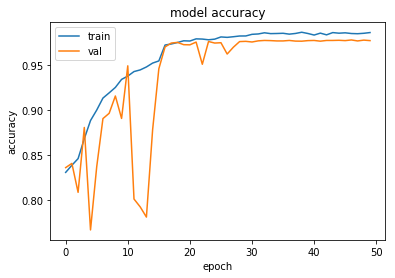

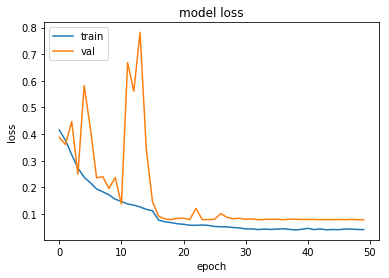

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
X_test = []
test_df = pd.read_csv(data_path + 'test.csv')
for i in tqdm(test_df.values):
    X_test.append(preprocess_image(data_path + 'test/' + i[0]))
    
X_test = np.asarray(X_test)

In [0]:
# model.load_weights('cnn_weights_v6.h5')

In [0]:
res = []
for i in tqdm(test_df.values):
    res.append(np.argmax(model.predict(np.expand_dims(preprocess_image(data_path + 'test/' + i[0]), axis=0)))+3)

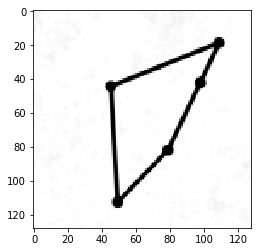

5


In [0]:
import matplotlib.pyplot as plt
idx = np.random.randint(0, 1000)
plt.imshow(X_test[16380][:,:,0], cmap='gray')
plt.show()
print(res[16380])

In [0]:
test_df['n_sides'] = res

In [0]:
test_df.to_csv('submission.csv', index=False)